<a href="https://colab.research.google.com/github/nan-hk/-motion-artifacts/blob/master/SPNet_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Not Used

In [ ]:
import torch.nn as nn
import math


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self,mode='rgb'):
        self.inplanes = 64
        super(ResNet50, self).__init__()
        if(mode=='rgb'):
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        elif(mode=='rgbd'):
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        elif(mode=="share"):
            self.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
            self.conv1_d=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        else:
            raise 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3_1 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_1 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.inplanes = 512

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x1 = self.layer3_1(x)
        x1 = self.layer4_1(x1)

        return x1, x1


# Eval Dataset

In [ ]:
from torch.utils import data
import torch
import os
from PIL import Image
class EvalDataset(data.Dataset):
    def __init__(self, img_root, label_root):
        
        self.image_path = list(map(lambda x: os.path.join(img_root, x), sorted(os.listdir(img_root))))
        self.label_path = list(map(lambda x: os.path.join(label_root, x), sorted(os.listdir(label_root))))

    def __getitem__(self, item):
        pred = Image.open(self.image_path[item]).convert('L')

        gt = Image.open(self.label_path[item]).convert('L')
        # print(self.image_path[item], self.label_path[item])
        if pred.size != gt.size:
            pred = pred.resize(gt.size, Image.BILINEAR)
        return pred, gt

    def __len__(self):
        return len(self.image_path)
    

#EVAL Fun

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 17:21:18 2020

@author: taozhou
"""

import os
import time

import numpy as np
import torch
from torchvision import transforms


###############################################################################
## basic funcs
###############################################################################

def fun_eval_e(y_pred, y, num, cuda=True):
    
    if cuda:
        score = torch.zeros(num).cuda()
    else:
        score = torch.zeros(num)
    
    for i in range(num):
        
        fm = y_pred - y_pred.mean()
        gt = y - y.mean()
        align_matrix = 2 * gt * fm / (gt * gt + fm * fm + 1e-20)
        enhanced = ((align_matrix + 1) * (align_matrix + 1)) / 4
        score[i] = torch.sum(enhanced) / (y.numel() - 1 + 1e-20)        
    return score.max()


def fun_eval_pr(y_pred, y, num, cuda=True):
    
    if cuda:
        prec, recall = torch.zeros(num).cuda(), torch.zeros(num).cuda()
        thlist = torch.linspace(0, 1 - 1e-10, num).cuda()
    else:
        prec, recall = torch.zeros(num), torch.zeros(num)
        thlist = torch.linspace(0, 1 - 1e-10, num)
    
    for i in range(num):
        y_temp = (y_pred >= thlist[i]).float()
        tp = (y_temp * y).sum()
        prec[i], recall[i] = tp / (y_temp.sum() + 1e-20), tp / (y.sum() + 1e-20)
    return prec, recall
    

def fun_S_object(pred, gt):
        
    fg = torch.where(gt==0, torch.zeros_like(pred), pred)
    bg = torch.where(gt==1, torch.zeros_like(pred), 1-pred)
    o_fg = fun_object(fg, gt)
    o_bg = fun_object(bg, 1-gt)
    u = gt.mean()
    Q = u * o_fg + (1-u) * o_bg
    return Q


def fun_object(pred, gt):
    
    temp = pred[gt == 1]
    x = temp.mean()
    sigma_x = temp.std()
    score = 2.0 * x / (x * x + 1.0 + sigma_x + 1e-20)
        
    return score


def fun_S_region(pred, gt):
    
    X, Y = fun_centroid(gt)
    gt1, gt2, gt3, gt4, w1, w2, w3, w4 = fun_divideGT(gt, X, Y)
    p1, p2, p3, p4 = fun_dividePrediction(pred, X, Y)
    Q1 = fun_ssim(p1, gt1)
    Q2 = fun_ssim(p2, gt2)
    Q3 = fun_ssim(p3, gt3)
    Q4 = fun_ssim(p4, gt4)
    Q = w1*Q1 + w2*Q2 + w3*Q3 + w4*Q4
    
    return Q
    
def fun_centroid(gt, cuda=True):
    
    rows, cols = gt.size()[-2:]
    gt = gt.view(rows, cols)
    
    if gt.sum() == 0:
        
        if cuda:
            X = torch.eye(1).cuda() * round(cols / 2)
            Y = torch.eye(1).cuda() * round(rows / 2)
        else:
            X = torch.eye(1) * round(cols / 2)
            Y = torch.eye(1) * round(rows / 2)
    
    else:
        total = gt.sum()
        
        if cuda:
            i = torch.from_numpy(np.arange(0,cols)).cuda().float()
            j = torch.from_numpy(np.arange(0,rows)).cuda().float()
        else:
            i = torch.from_numpy(np.arange(0,cols)).float()
            j = torch.from_numpy(np.arange(0,rows)).float()
            
        X = torch.round((gt.sum(dim=0)*i).sum() / total)
        Y = torch.round((gt.sum(dim=1)*j).sum() / total)
        
    return X.long(), Y.long()
  
    
def fun_divideGT(gt, X, Y):
    
    h, w = gt.size()[-2:]
    area = h*w
    gt   = gt.view(h, w)
    LT   = gt[:Y, :X]
    RT   = gt[:Y, X:w]
    LB   = gt[Y:h, :X]
    RB   = gt[Y:h, X:w]
    X    = X.float()
    Y    = Y.float()
    w1   = X * Y / area
    w2   = (w - X) * Y / area
    w3   = X * (h - Y) / area
    w4   = 1 - w1 - w2 - w3
    
    return LT, RT, LB, RB, w1, w2, w3, w4

def fun_dividePrediction(pred, X, Y):
    
    h, w = pred.size()[-2:]
    pred = pred.view(h, w)
    LT = pred[:Y, :X]
    RT = pred[:Y, X:w]
    LB = pred[Y:h, :X]
    RB = pred[Y:h, X:w]
        
    return LT, RT, LB, RB


def fun_ssim(pred, gt):
    
    gt       = gt.float()
    h, w     = pred.size()[-2:]
    N        = h*w
    x        = pred.mean()
    y        = gt.mean()
    sigma_x2 = ((pred - x)*(pred - x)).sum() / (N - 1 + 1e-20)
    sigma_y2 = ((gt - y)*(gt - y)).sum() / (N - 1 + 1e-20)
    sigma_xy = ((pred - x)*(gt - y)).sum() / (N - 1 + 1e-20)
        
    aplha = 4 * x * y *sigma_xy
    beta = (x*x + y*y) * (sigma_x2 + sigma_y2)
    
    if aplha != 0:
        Q = aplha / (beta + 1e-20)
    elif aplha == 0 and beta == 0:
        Q = 1.0
    else:
        Q = 0
    
    return Q

###############################################################################
## metric funcs
###############################################################################
def eval_mae(pred,gt,cuda=True):
    
    with torch.no_grad():
    
        trans = transforms.Compose([transforms.ToTensor()])
        
        if cuda:
            pred = pred.cuda()
            gt   = gt.cuda()
#        else:
#            pred = trans(pred)
#            gt = trans(gt)
                
        mae = torch.abs(pred - gt).mean()
        
    return mae.cpu().detach().numpy()
                

def eval_Smeasure(pred,gt,cuda=True):
    
    alpha, avg_q, img_num = 0.5, 0.0, 0.0
   
    with torch.no_grad():
        
        trans = transforms.Compose([transforms.ToTensor()])
        
        if cuda:
            pred = pred.cuda()
            gt   = gt.cuda()

        
        y = gt.mean()
        
        ##
        if y == 0:
            x = pred.mean()
            Q = 1.0 - x
        elif y == 1:
            x = pred.mean()
            Q = x
        else:
            Q = alpha * fun_S_object(pred, gt) + (1-alpha) * fun_S_region(pred, gt)
            if Q.item() < 0:
                Q = torch.FLoatTensor([0.0])
                
    return Q.item()

                
def eval_fmeasure(pred, gt, cuda=True):
    print('eval[FMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
    
    beta2 = 0.3
    avg_p, avg_r, img_num = 0.0, 0.0, 0.0
    
    ##    
    with torch.no_grad():
        trans = transforms.Compose([transforms.ToTensor()])
        if cuda:
            pred = trans(pred).cuda()
            gt = trans(gt).cuda()
        else:
            pred = trans(pred)
            gt = trans(gt)
                
        prec, recall = fun_eval_pr(pred, gt, 255)

    return prec, recall
              

class Eval_thread():
    def __init__(self, loader, method, dataset, output_dir, cuda):
        self.loader = loader
        self.method = method
        self.dataset = dataset
        self.cuda = cuda
        self.logfile = os.path.join(output_dir, 'result.txt')
    def run(self):
        start_time = time.time()
        mae = self.Eval_mae()
        s = self.Eval_Smeasure()
        
        return mae,s
        
        #max_f = self.Eval_fmeasure()
        #max_e = self.Eval_Emeasure()
        
        #self.LOG('{} dataset with {} method get {:.4f} mae, {:.4f} max-fmeasure, {:.4f} max-Emeasure, {:.4f} S-measure..\n'.format(self.dataset, self.method, mae, max_f, max_e, s))
        #return '[cost:{:.4f}s]{} dataset with {} method get {:.4f} mae, {:.4f} max-fmeasure, {:.4f} max-Emeasure, {:.4f} S-measure..'.format(time.time()-start_time, self.dataset, self.method, mae, max_f, max_e, s)
    
    def Eval_mae(self):
        
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                mea = torch.abs(pred - gt).mean()
                if mea == mea: # for Nan
                    avg_mae += mea
                    img_num += 1.0
            avg_mae /= img_num
            
            return avg_mae.item()
    
    def Eval_fmeasure(self):
        print('eval[FMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        beta2 = 0.3
        avg_p, avg_r, img_num = 0.0, 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                prec, recall = self._eval_pr(pred, gt, 255)
                avg_p += prec
                avg_r += recall
                img_num += 1.0
            avg_p /= img_num
            avg_r /= img_num
            score = (1 + beta2) * avg_p * avg_r / (beta2 * avg_p + avg_r)
            score[score != score] = 0 # for Nan
            
            return score.max().item()
    def Eval_Emeasure(self):
        print('eval[EMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        avg_e, img_num = 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                max_e = self._eval_e(pred, gt, 255)
                if max_e == max_e:
                    avg_e += max_e
                    img_num += 1.0
                
            avg_e /= img_num
            return avg_e
    def Eval_Smeasure(self):
        #print('eval[SMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        alpha, avg_q, img_num = 0.5, 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                y = gt.mean()
                if y == 0:
                    x = pred.mean()
                    Q = 1.0 - x
                elif y == 1:
                    x = pred.mean()
                    Q = x
                else:
                    Q = alpha * self._S_object(pred, gt) + (1-alpha) * self._S_region(pred, gt)
                    if Q.item() < 0:
                        Q = torch.FLoatTensor([0.0])
                img_num += 1.0
                avg_q += Q.item()
            avg_q /= img_num
            
            return avg_q
    def LOG(self, output):
        with open(self.logfile, 'a') as f:
            f.write(output)

    def _eval_e(self, y_pred, y, num):
        if self.cuda:
            score = torch.zeros(num).cuda()
        else:
            score = torch.zeros(num)
        for i in range(num):
            fm = y_pred - y_pred.mean()
            gt = y - y.mean()
            align_matrix = 2 * gt * fm / (gt * gt + fm * fm + 1e-20)
            enhanced = ((align_matrix + 1) * (align_matrix + 1)) / 4
            score[i] = torch.sum(enhanced) / (y.numel() - 1 + 1e-20)
        return score.max()

    def _eval_pr(self, y_pred, y, num):
        if self.cuda:
            prec, recall = torch.zeros(num).cuda(), torch.zeros(num).cuda()
            thlist = torch.linspace(0, 1 - 1e-10, num).cuda()
        else:
            prec, recall = torch.zeros(num), torch.zeros(num)
            thlist = torch.linspace(0, 1 - 1e-10, num)
        for i in range(num):
            y_temp = (y_pred >= thlist[i]).float()
            tp = (y_temp * y).sum()
            prec[i], recall[i] = tp / (y_temp.sum() + 1e-20), tp / (y.sum() + 1e-20)
        return prec, recall
    
    def _S_object(self, pred, gt):
        fg = torch.where(gt==0, torch.zeros_like(pred), pred)
        bg = torch.where(gt==1, torch.zeros_like(pred), 1-pred)
        o_fg = self._object(fg, gt)
        o_bg = self._object(bg, 1-gt)
        u = gt.mean()
        Q = u * o_fg + (1-u) * o_bg
        return Q

    def _object(self, pred, gt):
        temp = pred[gt == 1]
        x = temp.mean()
        sigma_x = temp.std()
        score = 2.0 * x / (x * x + 1.0 + sigma_x + 1e-20)
        
        return score

    def _S_region(self, pred, gt):
        X, Y = self._centroid(gt)
        gt1, gt2, gt3, gt4, w1, w2, w3, w4 = self._divideGT(gt, X, Y)
        p1, p2, p3, p4 = self._dividePrediction(pred, X, Y)
        Q1 = self._ssim(p1, gt1)
        Q2 = self._ssim(p2, gt2)
        Q3 = self._ssim(p3, gt3)
        Q4 = self._ssim(p4, gt4)
        Q = w1*Q1 + w2*Q2 + w3*Q3 + w4*Q4
        # print(Q)
        return Q
    
    def _centroid(self, gt):
        rows, cols = gt.size()[-2:]
        gt = gt.view(rows, cols)
        if gt.sum() == 0:
            if self.cuda:
                X = torch.eye(1).cuda() * round(cols / 2)
                Y = torch.eye(1).cuda() * round(rows / 2)
            else:
                X = torch.eye(1) * round(cols / 2)
                Y = torch.eye(1) * round(rows / 2)
        else:
            total = gt.sum()
            if self.cuda:
                i = torch.from_numpy(np.arange(0,cols)).cuda().float()
                j = torch.from_numpy(np.arange(0,rows)).cuda().float()
            else:
                i = torch.from_numpy(np.arange(0,cols)).float()
                j = torch.from_numpy(np.arange(0,rows)).float()
            X = torch.round((gt.sum(dim=0)*i).sum() / total)
            Y = torch.round((gt.sum(dim=1)*j).sum() / total)
        return X.long(), Y.long()
    
    def _divideGT(self, gt, X, Y):
        h, w = gt.size()[-2:]
        area = h*w
        gt = gt.view(h, w)
        LT = gt[:Y, :X]
        RT = gt[:Y, X:w]
        LB = gt[Y:h, :X]
        RB = gt[Y:h, X:w]
        X = X.float()
        Y = Y.float()
        w1 = X * Y / area
        w2 = (w - X) * Y / area
        w3 = X * (h - Y) / area
        w4 = 1 - w1 - w2 - w3
        return LT, RT, LB, RB, w1, w2, w3, w4

    def _dividePrediction(self, pred, X, Y):
        h, w = pred.size()[-2:]
        pred = pred.view(h, w)
        LT = pred[:Y, :X]
        RT = pred[:Y, X:w]
        LB = pred[Y:h, :X]
        RB = pred[Y:h, X:w]
        return LT, RT, LB, RB

    def _ssim(self, pred, gt):
        gt = gt.float()
        h, w = pred.size()[-2:]
        N = h*w
        x = pred.mean()
        y = gt.mean()
        sigma_x2 = ((pred - x)*(pred - x)).sum() / (N - 1 + 1e-20)
        sigma_y2 = ((gt - y)*(gt - y)).sum() / (N - 1 + 1e-20)
        sigma_xy = ((pred - x)*(gt - y)).sum() / (N - 1 + 1e-20)
        
        aplha = 4 * x * y *sigma_xy
        beta = (x*x + y*y) * (sigma_x2 + sigma_y2)

        if aplha != 0:
            Q = aplha / (beta + 1e-20)
        elif aplha == 0 and beta == 0:
            Q = 1.0
        else:
            Q = 0
        return Q


#Evaluater

In [ ]:
import os
import time

import numpy as np
import torch
from torchvision import transforms


class Eval_thread():
    def __init__(self, loader, method, dataset, output_dir, cuda):
        self.loader = loader
        self.method = method
        self.dataset = dataset
        self.cuda = cuda
        self.logfile = os.path.join(output_dir, 'result.txt')
    def run(self):
        start_time = time.time()
        mae = self.Eval_mae()
        s = self.Eval_Smeasure()
        
        
        
        max_f = self.Eval_fmeasure()
        max_e = self.Eval_Emeasure()
        
        return mae,s,max_f,max_e
    
        
        #self.LOG('{} dataset with {} method get {:.4f} mae, {:.4f} max-fmeasure, {:.4f} max-Emeasure, {:.4f} S-measure..\n'.format(self.dataset, self.method, mae, max_f, max_e, s))
        #return '[cost:{:.4f}s]{} dataset with {} method get {:.4f} mae, {:.4f} max-fmeasure, {:.4f} max-Emeasure, {:.4f} S-measure..'.format(time.time()-start_time, self.dataset, self.method, mae, max_f, max_e, s)
    
    def Eval_mae(self):
        #print('eval[MAE]:{} dataset with {} method.'.format(self.dataset, self.method))
        avg_mae, img_num = 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                mea = torch.abs(pred - gt).mean()
                if mea == mea: # for Nan
                    avg_mae += mea
                    img_num += 1.0
            avg_mae /= img_num
            
            return avg_mae.item()
    
    def Eval_fmeasure(self):
        print('eval[FMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        beta2 = 0.3
        avg_p, avg_r, img_num = 0.0, 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                prec, recall = self._eval_pr(pred, gt, 255)
                avg_p += prec
                avg_r += recall
                img_num += 1.0
            avg_p /= img_num
            avg_r /= img_num
            score = (1 + beta2) * avg_p * avg_r / (beta2 * avg_p + avg_r)
            score[score != score] = 0 # for Nan
            
            return score.max().item()
    def Eval_Emeasure(self):
        print('eval[EMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        avg_e, img_num = 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                max_e = self._eval_e(pred, gt, 255)
                if max_e == max_e:
                    avg_e += max_e
                    img_num += 1.0
                
            avg_e /= img_num
            return avg_e.item()
    def Eval_Smeasure(self):
        #print('eval[SMeasure]:{} dataset with {} method.'.format(self.dataset, self.method))
        alpha, avg_q, img_num = 0.5, 0.0, 0.0
        with torch.no_grad():
            trans = transforms.Compose([transforms.ToTensor()])
            for pred, gt in self.loader:
                if self.cuda:
                    pred = trans(pred).cuda()
                    gt = trans(gt).cuda()
                else:
                    pred = trans(pred)
                    gt = trans(gt)
                y = gt.mean()
                if y == 0:
                    x = pred.mean()
                    Q = 1.0 - x
                elif y == 1:
                    x = pred.mean()
                    Q = x
                else:
                    Q = alpha * self._S_object(pred, gt) + (1-alpha) * self._S_region(pred, gt)
                    if Q.item() < 0:
                        Q = torch.FLoatTensor([0.0])
                img_num += 1.0
                avg_q += Q.item()
            avg_q /= img_num
            
            return avg_q
    def LOG(self, output):
        with open(self.logfile, 'a') as f:
            f.write(output)

    def _eval_e(self, y_pred, y, num):
        if self.cuda:
            score = torch.zeros(num).cuda()
        else:
            score = torch.zeros(num)
        for i in range(num):
            fm = y_pred - y_pred.mean()
            gt = y - y.mean()
            align_matrix = 2 * gt * fm / (gt * gt + fm * fm + 1e-20)
            enhanced = ((align_matrix + 1) * (align_matrix + 1)) / 4
            score[i] = torch.sum(enhanced) / (y.numel() - 1 + 1e-20)
        return score.max()

    def _eval_pr(self, y_pred, y, num):
        if self.cuda:
            prec, recall = torch.zeros(num).cuda(), torch.zeros(num).cuda()
            thlist = torch.linspace(0, 1 - 1e-10, num).cuda()
        else:
            prec, recall = torch.zeros(num), torch.zeros(num)
            thlist = torch.linspace(0, 1 - 1e-10, num)
        for i in range(num):
            y_temp = (y_pred >= thlist[i]).float()
            tp = (y_temp * y).sum()
            prec[i], recall[i] = tp / (y_temp.sum() + 1e-20), tp / (y.sum() + 1e-20)
        return prec, recall
    
    def _S_object(self, pred, gt):
        fg = torch.where(gt==0, torch.zeros_like(pred), pred)
        bg = torch.where(gt==1, torch.zeros_like(pred), 1-pred)
        o_fg = self._object(fg, gt)
        o_bg = self._object(bg, 1-gt)
        u = gt.mean()
        Q = u * o_fg + (1-u) * o_bg
        return Q

    def _object(self, pred, gt):
        temp = pred[gt == 1]
        x = temp.mean()
        sigma_x = temp.std()
        score = 2.0 * x / (x * x + 1.0 + sigma_x + 1e-20)
        
        return score

    def _S_region(self, pred, gt):
        X, Y = self._centroid(gt)
        gt1, gt2, gt3, gt4, w1, w2, w3, w4 = self._divideGT(gt, X, Y)
        p1, p2, p3, p4 = self._dividePrediction(pred, X, Y)
        Q1 = self._ssim(p1, gt1)
        Q2 = self._ssim(p2, gt2)
        Q3 = self._ssim(p3, gt3)
        Q4 = self._ssim(p4, gt4)
        Q = w1*Q1 + w2*Q2 + w3*Q3 + w4*Q4
        # print(Q)
        return Q
    
    def _centroid(self, gt):
        rows, cols = gt.size()[-2:]
        gt = gt.view(rows, cols)
        if gt.sum() == 0:
            if self.cuda:
                X = torch.eye(1).cuda() * round(cols / 2)
                Y = torch.eye(1).cuda() * round(rows / 2)
            else:
                X = torch.eye(1) * round(cols / 2)
                Y = torch.eye(1) * round(rows / 2)
        else:
            total = gt.sum()
            if self.cuda:
                i = torch.from_numpy(np.arange(0,cols)).cuda().float()
                j = torch.from_numpy(np.arange(0,rows)).cuda().float()
            else:
                i = torch.from_numpy(np.arange(0,cols)).float()
                j = torch.from_numpy(np.arange(0,rows)).float()
            X = torch.round((gt.sum(dim=0)*i).sum() / total)
            Y = torch.round((gt.sum(dim=1)*j).sum() / total)
        return X.long(), Y.long()
    
    def _divideGT(self, gt, X, Y):
        h, w = gt.size()[-2:]
        area = h*w
        gt = gt.view(h, w)
        LT = gt[:Y, :X]
        RT = gt[:Y, X:w]
        LB = gt[Y:h, :X]
        RB = gt[Y:h, X:w]
        X = X.float()
        Y = Y.float()
        w1 = X * Y / area
        w2 = (w - X) * Y / area
        w3 = X * (h - Y) / area
        w4 = 1 - w1 - w2 - w3
        return LT, RT, LB, RB, w1, w2, w3, w4

    def _dividePrediction(self, pred, X, Y):
        h, w = pred.size()[-2:]
        pred = pred.view(h, w)
        LT = pred[:Y, :X]
        RT = pred[:Y, X:w]
        LB = pred[Y:h, :X]
        RB = pred[Y:h, X:w]
        return LT, RT, LB, RB

    def _ssim(self, pred, gt):
        gt = gt.float()
        h, w = pred.size()[-2:]
        N = h*w
        x = pred.mean()
        y = gt.mean()
        sigma_x2 = ((pred - x)*(pred - x)).sum() / (N - 1 + 1e-20)
        sigma_y2 = ((gt - y)*(gt - y)).sum() / (N - 1 + 1e-20)
        sigma_xy = ((pred - x)*(gt - y)).sum() / (N - 1 + 1e-20)
        
        aplha = 4 * x * y *sigma_xy
        beta = (x*x + y*y) * (sigma_x2 + sigma_y2)

        if aplha != 0:
            Q = aplha / (beta + 1e-20)
        elif aplha == 0 and beta == 0:
            Q = 1.0
        else:
            Q = 0
        return Q


# Start From here

In [ ]:
#train
!pip install tensorboardX --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.2 MB/s 


In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

#zip_ref = zipfile.ZipFile("/content/drive/My Drive/TrainDataset_update.zip", 'r') (depth_art_less)
#zip_ref = zipfile.ZipFile("/content/drive/My Drive/traindataset.zip", 'r') (depth_more_art)
zip_ref = zipfile.ZipFile("/content/drive/My Drive/traindataset_only_depth.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:

#zip_ref = zipfile.ZipFile("/content/drive/My Drive/TestDataset_update.zip", 'r') (depth_art_less)
#zip_ref = zipfile.ZipFile("/content/drive/My Drive/testdataset.zip", 'r')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/testdataset_only_depth.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

#Rest2Net model

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F
__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b']


model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale = 4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth/64.0)))
        self.conv1 = nn.Conv2d(inplanes, width*scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width*scale)
        
        if scale == 1:
          self.nums = 1
        else:
          self.nums = scale -1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride = stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
          convs.append(nn.Conv2d(width, width, kernel_size=3, stride = stride, padding=1, bias=False))
          bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width*scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width  = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
          if i==0 or self.stype=='stage':
            sp = spx[i]
          else:
            sp = sp + spx[i]
          sp = self.convs[i](sp)
          sp = self.relu(self.bns[i](sp))
          if i==0:
            out = sp
          else:
            out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype=='normal':
          out = torch.cat((out, spx[self.nums]),1)
        elif self.scale != 1 and self.stype=='stage':
          out = torch.cat((out, self.pool(spx[self.nums])),1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth = 26, scale = 4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride, 
                    ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion, 
                    kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample, 
                        stype='stage', baseWidth = self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth = self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x0 = self.maxpool(x)
        

        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x5 = self.avgpool(x4)
        x6 = x5.view(x5.size(0), -1)
        x7 = self.fc(x6)

        return x7



class Res2Net_Ours(nn.Module):

    def __init__(self, block, layers, baseWidth = 26, scale = 4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net_Ours, self).__init__()
        
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
       

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride, 
                    ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion, 
                    kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample, 
                        stype='stage', baseWidth = self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth = self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x0 = self.maxpool(x)
        

        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)


        return x0,x1,x2,x3,x4
    
    

def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s'],map_location='cpu'))
    return model

def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model



def res2net50_v1b_Ours(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net_Ours(Bottle2neck, [3, 4, 6, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model

def res2net101_v1b_Ours(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net_Ours(Bottle2neck, [3, 4, 23, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model



def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s'],map_location='cpu'))
    return model

def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model

def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth = 26, scale = 4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model



   
def Res2Net_model(ind=50):
    
    if ind == 50:
        model_base = res2net50_v1b(pretrained=True)
        model      = res2net50_v1b_Ours()

    if ind == 101:
        model_base = res2net101_v1b(pretrained=True)
        model      = res2net101_v1b_Ours()
        
        
    pretrained_dict = model_base.state_dict()
    model_dict      = model.state_dict()
    
    pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    return model





if __name__ == '__main__':
    images = torch.rand(1, 3, 352, 352)
    model = res2net50_v1b_26w_4s(pretrained=False)
    model = model
    print(model(images).size())


torch.Size([1, 1000])


#SPNet Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x



#Global Contextual module
class GCM(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GCM, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x



###############################################################################

class CIM0(nn.Module):    
    def __init__(self,in_dim, out_dim):
        super(CIM0, self).__init__()
        
        act_fn = nn.ReLU(inplace=True)
        

        self.layer_10 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)
        self.layer_20 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)   
        
        self.layer_11 = nn.Sequential(nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)        
        self.layer_21 = nn.Sequential(nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)
        
        self.gamma1 = nn.Parameter(torch.zeros(1))
        self.gamma2 = nn.Parameter(torch.zeros(1))
        

        self.layer_ful1 = nn.Sequential(nn.Conv2d(out_dim*2, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)
        

    def forward(self, rgb, depth):
        
        ################################
        
        x_rgb = self.layer_10(rgb)
        x_dep = self.layer_20(depth)
        
        rgb_w = nn.Sigmoid()(x_rgb)
        dep_w = nn.Sigmoid()(x_dep)
        
        ##
        x_rgb_w = rgb.mul(dep_w)
        x_dep_w = depth.mul(rgb_w)
        
        x_rgb_r = x_rgb_w + rgb
        x_dep_r = x_dep_w + depth
        
        ## fusion 
        x_rgb_r = self.layer_11(x_rgb_r)
        x_dep_r = self.layer_21(x_dep_r)
        
        
        ful_mul = torch.mul(x_rgb_r, x_dep_r)         
        x_in1   = torch.reshape(x_rgb_r,[x_rgb_r.shape[0],1,x_rgb_r.shape[1],x_rgb_r.shape[2],x_rgb_r.shape[3]])
        x_in2   = torch.reshape(x_dep_r,[x_dep_r.shape[0],1,x_dep_r.shape[1],x_dep_r.shape[2],x_dep_r.shape[3]])
        x_cat   = torch.cat((x_in1, x_in2),dim=1)
        ful_max = x_cat.max(dim=1)[0]
        ful_out = torch.cat((ful_mul,ful_max),dim=1)
        
        out1 = self.layer_ful1(ful_out)
         
        return out1


class CIM(nn.Module):    
    def __init__(self,in_dim, out_dim):
        super(CIM, self).__init__()
        
        act_fn = nn.ReLU(inplace=True)
        
        self.reduc_1 = nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size=1), act_fn)
        self.reduc_2 = nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size=1), act_fn)
        
        self.layer_10 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)
        self.layer_20 = nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1)   
        
        self.layer_11 = nn.Sequential(nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)        
        self.layer_21 = nn.Sequential(nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)
        
        self.gamma1 = nn.Parameter(torch.zeros(1))
        self.gamma2 = nn.Parameter(torch.zeros(1))
        

        self.layer_ful1 = nn.Sequential(nn.Conv2d(out_dim*2, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)
        self.layer_ful2 = nn.Sequential(nn.Conv2d(out_dim+out_dim//2, out_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(out_dim),act_fn,)

    def forward(self, rgb, depth, xx):
        
        ################################
        x_rgb = self.reduc_1(rgb)
        x_dep = self.reduc_2(depth)
        
        x_rgb1 = self.layer_10(x_rgb)
        x_dep1 = self.layer_20(x_dep)
        
        rgb_w = nn.Sigmoid()(x_rgb1)
        dep_w = nn.Sigmoid()(x_dep1)
        
        ##
        x_rgb_w = x_rgb.mul(dep_w)
        x_dep_w = x_dep.mul(rgb_w)
        
        x_rgb_r = x_rgb_w + x_rgb
        x_dep_r = x_dep_w + x_dep
        
        ## fusion 
        x_rgb_r = self.layer_11(x_rgb_r)
        x_dep_r = self.layer_21(x_dep_r)
        
        
        ful_mul = torch.mul(x_rgb_r, x_dep_r)         
        x_in1   = torch.reshape(x_rgb_r,[x_rgb_r.shape[0],1,x_rgb_r.shape[1],x_rgb_r.shape[2],x_rgb_r.shape[3]])
        x_in2   = torch.reshape(x_dep_r,[x_dep_r.shape[0],1,x_dep_r.shape[1],x_dep_r.shape[2],x_dep_r.shape[3]])
        x_cat   = torch.cat((x_in1, x_in2),dim=1)
        ful_max = x_cat.max(dim=1)[0]
        ful_out = torch.cat((ful_mul,ful_max),dim=1)
        
        out1 = self.layer_ful1(ful_out)
        out2 = self.layer_ful2(torch.cat([out1,xx],dim=1))
         
        return out2



class MFA(nn.Module):    
    def __init__(self,in_dim):
        super(MFA, self).__init__()
         
        self.relu = nn.ReLU(inplace=True)
        
        self.layer_10 = nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=1, padding=1)
        self.layer_20 = nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=1, padding=1)   
        self.layer_cat1 = nn.Sequential(nn.Conv2d(in_dim*2, in_dim, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(in_dim),)        
        
    def forward(self, x_ful, x1, x2):
        
        ################################
    
        x_ful_1 = x_ful.mul(x1)
        x_ful_2 = x_ful.mul(x2)
        
     
        x_ful_w = self.layer_cat1(torch.cat([x_ful_1, x_ful_2],dim=1))
        out     = self.relu(x_ful + x_ful_w)
        
        return out
    
    

  
   
###############################################################################

class SPNet(nn.Module):
    def __init__(self, channel=32,ind=50):
        super(SPNet, self).__init__()
        
       
        self.relu = nn.ReLU(inplace=True)
        
        self.upsample_2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample_4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample_8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        
        #Backbone model
        #Backbone model
        self.layer_rgb  = Res2Net_model(ind)
        self.layer_dep  = Res2Net_model(ind)
        
        self.layer_dep0 = nn.Conv2d(1, 3, kernel_size=1)
        
        ###############################################
        # funsion encoders #
        ###############################################
        self.fu_0 = CIM0(64, 64)#
        
        self.fu_1 = CIM(256, 128) #MixedFusion_Block_IMfusion
        self.pool_fu_1 = maxpool()
        
        self.fu_2 = CIM(512, 256)
        self.pool_fu_2 = maxpool()
        
        self.fu_3 = CIM(1024, 512)
        self.pool_fu_3 = maxpool()

        self.fu_4 = CIM(2048, 1024)
        self.pool_fu_4 = maxpool()
        
        
        ###############################################
        # decoders #
        ###############################################
        
        ## rgb
        self.rgb_conv_4   = nn.Sequential(BasicConv2d(2048,    256, 3, padding=1),self.relu)
        self.rgb_gcm_4    = GCM(2048,  channel)
        
        self.rgb_conv_3   = nn.Sequential(BasicConv2d(1024+32, 256, 3, padding=1),self.relu)
        self.rgb_gcm_3    = GCM(1024+32,  channel)

        self.rgb_conv_2   = nn.Sequential(BasicConv2d(512+32, 128, 3, padding=1),self.relu)
        self.rgb_gcm_2    = GCM(512+32,  channel)

        self.rgb_conv_1   = nn.Sequential(BasicConv2d(256+32, 128, 3, padding=1),self.relu)
        self.rgb_gcm_1    = GCM(256+32,  channel)

        self.rgb_conv_0   = nn.Sequential(BasicConv2d(64+32, 64, 3, padding=1),self.relu)
        self.rgb_gcm_0    = GCM(64+32,  channel)        
        self.rgb_conv_out = nn.Conv2d(channel, 1, 1)
        
        ## depth
        self.dep_conv_4   = nn.Sequential(BasicConv2d(2048, 256, 3, padding=1),self.relu)
        self.dep_gcm_4    = GCM(2048,  channel)
        
        self.dep_conv_3   = nn.Sequential(BasicConv2d(1024+32, 256, 3, padding=1),self.relu)
        self.dep_gcm_3    = GCM(1024+32,  channel)

        self.dep_conv_2   = nn.Sequential(BasicConv2d(512+32, 128, 3, padding=1),self.relu)
        self.dep_gcm_2    = GCM(512+32,  channel)

        self.dep_conv_1   = nn.Sequential(BasicConv2d(256+32, 128, 3, padding=1),self.relu)
        self.dep_gcm_1    = GCM(256+32,  channel)

        self.dep_conv_0   = nn.Sequential(BasicConv2d(64+32, 64, 3, padding=1),self.relu)
        self.dep_gcm_0    = GCM(64+32,  channel)        
        self.dep_conv_out = nn.Conv2d(channel, 1, 1)
        
        ## fusion
        self.ful_conv_4   = nn.Sequential(BasicConv2d(2048, 256, 3, padding=1),self.relu)
        self.ful_gcm_4    = GCM(1024,  channel)
        
        self.ful_conv_3   = nn.Sequential(BasicConv2d(1024+32*3, 256, 3, padding=1),self.relu)
        self.ful_gcm_3    = GCM(512+32,  channel)

        self.ful_conv_2   = nn.Sequential(BasicConv2d(512+32*3, 128, 3, padding=1),self.relu)
        self.ful_gcm_2    = GCM(256+32,  channel)

        self.ful_conv_1   = nn.Sequential(BasicConv2d(256+32*3, 128, 3, padding=1),self.relu)
        self.ful_gcm_1    = GCM(128+32,  channel)

        self.ful_conv_0   = nn.Sequential(BasicConv2d(128+32*3, 64, 3, padding=1),self.relu)
        self.ful_gcm_0    = GCM(64+32,  channel)        
        self.ful_conv_out = nn.Conv2d(channel, 1, 1)
        
        self.ful_layer4   = MFA(channel)
        self.ful_layer3   = MFA(channel)
        self.ful_layer2   = MFA(channel)
        self.ful_layer1   = MFA(channel)
        self.ful_layer0   = MFA(channel)
        
                

    def forward(self, imgs, depths):
        
        img_0, img_1, img_2, img_3, img_4 = self.layer_rgb(imgs)
        dep_0, dep_1, dep_2, dep_3, dep_4 = self.layer_dep(self.layer_dep0(depths))
        
    
      
        ####################################################
        ## fusion
        ####################################################
        ful_0    = self.fu_0(img_0, dep_0)
        ful_1    = self.fu_1(img_1, dep_1, ful_0)
        ful_2    = self.fu_2(img_2, dep_2, self.pool_fu_1(ful_1))
        ful_3    = self.fu_3(img_3, dep_3, self.pool_fu_2(ful_2))
        ful_4    = self.fu_4(img_4, dep_4, self.pool_fu_3(ful_3))
        
        ####################################################
        ## decoder rgb
        ####################################################        
        #
        x_rgb_42    = self.rgb_gcm_4(img_4)
        
        x_rgb_3_cat = torch.cat([img_3, self.upsample_2(x_rgb_42)], dim=1)
        x_rgb_32    = self.rgb_gcm_3(x_rgb_3_cat)
        
        x_rgb_2_cat = torch.cat([img_2, self.upsample_2(x_rgb_32)], dim=1)
        x_rgb_22    = self.rgb_gcm_2(x_rgb_2_cat)        

        x_rgb_1_cat = torch.cat([img_1, self.upsample_2(x_rgb_22)], dim=1)
        x_rgb_12    = self.rgb_gcm_1(x_rgb_1_cat)     

        x_rgb_0_cat = torch.cat([img_0, x_rgb_12], dim=1)
        x_rgb_02    = self.rgb_gcm_0(x_rgb_0_cat)     
        rgb_out     = self.upsample_4(self.rgb_conv_out(x_rgb_02))
        
        
        ####################################################
        ## decoder depth
        ####################################################        
        #
        x_dep_42    = self.dep_gcm_4(dep_4)
        
        x_dep_3_cat = torch.cat([dep_3, self.upsample_2(x_dep_42)], dim=1)
        x_dep_32    = self.dep_gcm_3(x_dep_3_cat)
        
        x_dep_2_cat = torch.cat([dep_2, self.upsample_2(x_dep_32)], dim=1)
        x_dep_22    = self.dep_gcm_2(x_dep_2_cat)        

        x_dep_1_cat = torch.cat([dep_1, self.upsample_2(x_dep_22)], dim=1)
        x_dep_12    = self.dep_gcm_1(x_dep_1_cat)     

        x_dep_0_cat = torch.cat([dep_0, x_dep_12], dim=1)
        x_dep_02    = self.dep_gcm_0(x_dep_0_cat)     
        dep_out     = self.upsample_4(self.dep_conv_out(x_dep_02))
        

        ####################################################
        ## decoder fusion
        ####################################################        
        #
        x_ful_42    = self.ful_gcm_4(ful_4)
        
        x_ful_3_cat = torch.cat([ful_3, self.ful_layer3(self.upsample_2(x_ful_42),self.upsample_2(x_rgb_42),self.upsample_2(x_dep_42))], dim=1)
        x_ful_32    = self.ful_gcm_3(x_ful_3_cat)
        
        x_ful_2_cat = torch.cat([ful_2, self.ful_layer2(self.upsample_2(x_ful_32),self.upsample_2(x_rgb_32),self.upsample_2(x_dep_32))], dim=1)
        x_ful_22    = self.ful_gcm_2(x_ful_2_cat)        

        x_ful_1_cat = torch.cat([ful_1, self.ful_layer1(self.upsample_2(x_ful_22),self.upsample_2(x_rgb_22),self.upsample_2(x_dep_22))], dim=1)
        x_ful_12    = self.ful_gcm_1(x_ful_1_cat)     

        x_ful_0_cat = torch.cat([ful_0, self.ful_layer0(x_ful_12, x_rgb_12, x_dep_12)], dim=1)
        x_ful_02    = self.ful_gcm_0(x_ful_0_cat)     
        ful_out     = self.upsample_4(self.ful_conv_out(x_ful_02))


        return rgb_out, dep_out, ful_out
    
    

    def _make_agant_layer(self, inplanes, planes):
        layers = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=1,
                      stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True)
        )
        return layers

    def _make_transpose(self, block, planes, blocks, stride=1):
        upsample = None
        if stride != 1:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.inplanes, planes,
                                   kernel_size=2, stride=stride,
                                   padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []

        for i in range(1, blocks):
            layers.append(block(self.inplanes, self.inplanes))

        layers.append(block(self.inplanes, planes, stride, upsample))
        self.inplanes = planes

        return nn.Sequential(*layers)
    
   

 

# Data Preparation

In [ ]:
import os
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import ImageEnhance

#several data augumentation strategies
def cv_random_flip(img, label,depth):
    flip_flag = random.randint(0, 1)
    # flip_flag2= random.randint(0,1)
    #left right flip
    if flip_flag == 1:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        label = label.transpose(Image.FLIP_LEFT_RIGHT)
        depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
    #top bottom flip
    # if flip_flag2==1:
    #     img = img.transpose(Image.FLIP_TOP_BOTTOM)
    #     label = label.transpose(Image.FLIP_TOP_BOTTOM)
    #     depth = depth.transpose(Image.FLIP_TOP_BOTTOM)
    return img, label, depth
def randomCrop(image, label,depth):
    border=30
    image_width = image.size[0]
    image_height = image.size[1]
    crop_win_width = np.random.randint(image_width-border , image_width)
    crop_win_height = np.random.randint(image_height-border , image_height)
    random_region = (
        (image_width - crop_win_width) >> 1, (image_height - crop_win_height) >> 1, (image_width + crop_win_width) >> 1,
        (image_height + crop_win_height) >> 1)
    return image.crop(random_region), label.crop(random_region),depth.crop(random_region)
def randomRotation(image,label,depth):
    mode=Image.BICUBIC
    if random.random()>0.8:
        random_angle = np.random.randint(-15, 15)
        image=image.rotate(random_angle, mode)
        label=label.rotate(random_angle, mode)
        depth=depth.rotate(random_angle, mode)
    return image,label,depth
def colorEnhance(image):
    bright_intensity=random.randint(5,15)/10.0
    image=ImageEnhance.Brightness(image).enhance(bright_intensity)
    contrast_intensity=random.randint(5,15)/10.0
    image=ImageEnhance.Contrast(image).enhance(contrast_intensity)
    color_intensity=random.randint(0,20)/10.0
    image=ImageEnhance.Color(image).enhance(color_intensity)
    sharp_intensity=random.randint(0,30)/10.0
    image=ImageEnhance.Sharpness(image).enhance(sharp_intensity)
    return image
def randomGaussian(image, mean=0.1, sigma=0.35):
    def gaussianNoisy(im, mean=mean, sigma=sigma):
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im
    img = np.asarray(image)
    width, height = img.shape
    img = gaussianNoisy(img[:].flatten(), mean, sigma)
    img = img.reshape([width, height])
    return Image.fromarray(np.uint8(img))
def randomPeper(img):

    img=np.array(img)
    noiseNum=int(0.0015*img.shape[0]*img.shape[1])
    for i in range(noiseNum):

        randX=random.randint(0,img.shape[0]-1)  

        randY=random.randint(0,img.shape[1]-1)  

        if random.randint(0,1)==0:  

            img[randX,randY]=0  

        else:  

            img[randX,randY]=255 
    return Image.fromarray(img)  

# dataset for training
#The current loader is not using the normalized depth maps for training and test. If you use the normalized depth maps
#(e.g., 0 represents background and 1 represents foreground.), the performance will be further improved.

class SalObjDataset(data.Dataset):
    def __init__(self, image_root, gt_root,depth_root, trainsize):
        self.trainsize = trainsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg')
                    or f.endswith('.png')]
        self.depths=[depth_root + f for f in os.listdir(depth_root) if f.endswith('.bmp')
                    or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.depths=sorted(self.depths)
        print('SalObjDat', )
        self.filter_files()
        self.size = len(self.images)
        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor()])
        self.depths_transform = transforms.Compose([transforms.Resize((self.trainsize, self.trainsize)),transforms.ToTensor()])

    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        depth=self.binary_loader(self.depths[index])
        image,gt,depth =cv_random_flip(image,gt,depth)
        image,gt,depth=randomCrop(image, gt,depth)
        image,gt,depth=randomRotation(image, gt,depth)
        image=colorEnhance(image)
        # gt=randomGaussian(gt)
        gt=randomPeper(gt)
        image = self.img_transform(image)
        gt = self.gt_transform(gt)
        depth=self.depths_transform(depth)
        
        return image, gt, depth

    def filter_files(self):
        print('SalObjDataset', self.images, self.gts)
        assert len(self.images) == len(self.gts) and len(self.gts)==len(self.images)
        images = []
        gts = []
        depths=[]
        for img_path, gt_path,depth_path in zip(self.images, self.gts, self.depths):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            depth= Image.open(depth_path)
            if img.size == gt.size and gt.size==depth.size:
                images.append(img_path)
                gts.append(gt_path)
                depths.append(depth_path)
        self.images = images
        self.gts = gts
        self.depths=depths

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def resize(self, img, gt, depth):
        assert img.size == gt.size and gt.size==depth.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST),depth.resize((w, h), Image.NEAREST)
        else:
            return img, gt, depth

    def __len__(self):
        return self.size


###############################################################################
# 0919
#

class SalObjDataset_var(data.Dataset):
    def __init__(self, image_root, gt_root,depth_root, trainsize):
        
        self.trainsize = trainsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg')]
        self.gts    = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.depths = [depth_root + f for f in os.listdir(depth_root) if f.endswith('.bmp') or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts    = sorted(self.gts)
        self.depths = sorted(self.depths)
        self.filter_files()
        self.size   = len(self.images)
        
        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor()])
        self.depths_transform = transforms.Compose([transforms.Resize((self.trainsize, self.trainsize)),transforms.ToTensor()])

    def __getitem__(self, index):
        
        ## read imag, gt, depth
        image0 = self.rgb_loader(self.images[index])
        gt0    = self.binary_loader(self.gts[index])
        depth0 = self.binary_loader(self.depths[index])
        
        
        ##################################################
        ## out1
        ##################################################
        image,gt,depth = cv_random_flip(image0,gt0,depth0)
        image,gt,depth = randomCrop(image, gt,depth)
        image,gt,depth = randomRotation(image, gt,depth)
        image          = colorEnhance(image)
        gt             = randomPeper(gt)
        image          = self.img_transform(image)
        gt             = self.gt_transform(gt)
        depth          = self.depths_transform(depth)

        ##################################################
        ## out1
        ##################################################
        image2,gt2,depth2 = cv_random_flip(image0,gt0,depth0)
        image2,gt2,depth2 = randomCrop(image2, gt2,depth2)
        image2,gt2,depth2 = randomRotation(image2, gt2,depth2)
        image2          = colorEnhance(image2)
        gt2             = randomPeper(gt2)
        image2          = self.img_transform(image2)
        gt2             = self.gt_transform(gt2)
        depth2          = self.depths_transform(depth2)

        
        return image, gt, depth, image2, gt2, depth2

    def filter_files(self):

        
        assert len(self.images) == len(self.gts) and len(self.gts)==len(self.images)
        images = []
        gts = []
        depths=[]
        for img_path, gt_path,depth_path in zip(self.images, self.gts, self.depths):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            depth= Image.open(depth_path)
            if img.size == gt.size and gt.size==depth.size:
                images.append(img_path)
                gts.append(gt_path)
                depths.append(depth_path)
        self.images = images
        self.gts = gts
        self.depths=depths

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def resize(self, img, gt, depth):
        assert img.size == gt.size and gt.size==depth.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST),depth.resize((w, h), Image.NEAREST)
        else:
            return img, gt, depth

    def __len__(self):
        return self.size



class SalObjDataset_var_unlabel(data.Dataset):
    def __init__(self, image_root, gt_root,depth_root, trainsize):
        
        self.trainsize = trainsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.png')]
        self.gts    = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.depths = [depth_root + f for f in os.listdir(depth_root) if f.endswith('.bmp') or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts    = sorted(self.gts)
        self.depths = sorted(self.depths)
        self.filter_files()
        self.size   = len(self.images)
        
        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor()])
        self.depths_transform = transforms.Compose([transforms.Resize((self.trainsize, self.trainsize)),transforms.ToTensor()])

    def __getitem__(self, index):
        
        ## read imag, gt, depth
        image0 = self.rgb_loader(self.images[index])
        gt0    = self.binary_loader(self.gts[index])
        depth0 = self.binary_loader(self.depths[index])
        
        
        ##################################################
        ## out1
        ##################################################
        image,gt,depth = cv_random_flip(image0,gt0,depth0)
        image,gt,depth = randomCrop(image, gt,depth)
        image,gt,depth = randomRotation(image, gt,depth)
        image          = colorEnhance(image)
        gt             = randomPeper(gt)
        image          = self.img_transform(image)
        gt             = self.gt_transform(gt)
        depth          = self.depths_transform(depth)

        ##################################################
        ## out1
        ##################################################
        image2,gt2,depth2 = cv_random_flip(image0,gt0,depth0)
        image2,gt2,depth2 = randomCrop(image2, gt2,depth2)
        image2,gt2,depth2 = randomRotation(image2, gt2,depth2)
        image2          = colorEnhance(image2)
        gt2             = randomPeper(gt2)
        image2          = self.img_transform(image2)
        gt2             = self.gt_transform(gt2)
        depth2          = self.depths_transform(depth2)

        
        return image, gt, depth, image2, gt2, depth2

    def filter_files(self):

        assert len(self.images) == len(self.gts) and len(self.gts)==len(self.images)
        images = []
        gts = []
        depths=[]
        for img_path, gt_path,depth_path in zip(self.images, self.gts, self.depths):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            depth= Image.open(depth_path)
            if img.size == gt.size and gt.size==depth.size:
                images.append(img_path)
                gts.append(gt_path)
                depths.append(depth_path)
        self.images = images
        self.gts = gts
        self.depths=depths

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def resize(self, img, gt, depth):
        assert img.size == gt.size and gt.size==depth.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST),depth.resize((w, h), Image.NEAREST)
        else:
            return img, gt, depth

    def __len__(self):
        return self.size

#dataloader for training
def get_loader(image_root, gt_root,depth_root, batchsize, trainsize, shuffle=True, num_workers=12, pin_memory=False):
    print(image_root, gt_root, depth_root)
    dataset = SalObjDataset(image_root, gt_root, depth_root,trainsize)
    print(dataset)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader


#dataloader for training2
## 09-19-2020
def get_loader_var(image_root, gt_root,depth_root, batchsize, trainsize, shuffle=True, num_workers=12, pin_memory=False):

    dataset = SalObjDataset_var(image_root, gt_root, depth_root,trainsize)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader


def get_loader_var_unlabel(image_root, gt_root,depth_root, batchsize, trainsize, shuffle=True, num_workers=12, pin_memory=False):

    dataset = SalObjDataset_var_unlabel(image_root, gt_root, depth_root,trainsize)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader


#test dataset and loader
class test_dataset:
    def __init__(self, image_root, gt_root,depth_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg')
                       or f.endswith('.png')]
        self.depths=[depth_root + f for f in os.listdir(depth_root) if f.endswith('.bmp')
                    or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.depths=sorted(self.depths)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.ToTensor()
        # self.gt_transform = transforms.Compose([
        #     transforms.Resize((self.trainsize, self.trainsize)),
        #     transforms.ToTensor()])
        self.depths_transform = transforms.Compose([transforms.Resize((self.testsize, self.testsize)),transforms.ToTensor()])
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        image = self.transform(image).unsqueeze(0)
        gt = self.binary_loader(self.gts[self.index])
        depth=self.binary_loader(self.depths[self.index])
        depth=self.depths_transform(depth).unsqueeze(0)
        name = self.images[self.index].split('/')[-1]
        image_for_post=self.rgb_loader(self.images[self.index])
        image_for_post=image_for_post.resize(gt.size)
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'
        self.index += 1
        self.index = self.index % self.size
        return image, gt,depth, name,np.array(image_for_post)

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')
    def __len__(self):
        return self.size



# Arguments

In [ ]:

import argparse

def arguments():
  parser = argparse.ArgumentParser()
  parser.add_argument('--epoch',       type=int,   default=500,   help='epoch number')
  parser.add_argument('--lr',          type=float, default=1e-4,  help='learning rate')
  parser.add_argument('--batchsize',   type=int,   default=4,    help='training batch size')
  parser.add_argument('--trainsize',   type=int,   default=352,   help='training dataset size')
  parser.add_argument('--clip',        type=float, default=0.5,   help='gradient clipping margin')
  parser.add_argument('--lw',          type=float, default=0.001, help='weight')
  parser.add_argument('--decay_rate',  type=float, default=0.1,   help='decay rate of learning rate')
  parser.add_argument('--decay_epoch', type=int,   default=60,    help='every n epochs decay learning rate')
  parser.add_argument('--load',        type=str,   default=None,  help='train from checkpoints')
  parser.add_argument('--gpu_id',      type=str,   default='0',   help='train use gpu')

  parser.add_argument('--rgb_label_root',      type=str, default='/content/tmp/traindataset_only_depth/RGB/',           help='the training rgb images root')
  parser.add_argument('--depth_label_root',    type=str, default='/content/tmp/traindataset_only_depth/depth/',         help='the training depth images root')
  parser.add_argument('--gt_label_root',       type=str, default='/content/tmp/traindataset_only_depth/GT/',            help='the training gt images root')

  parser.add_argument('--val_rgb_root',        type=str, default='/content/tmp/testdataset_only_depth/NJU2K/RGB/',      help='the test rgb images root')
  parser.add_argument('--val_depth_root',      type=str, default='/content/tmp/testdataset_only_depth/NJU2K/depth/',    help='the test depth images root')
  parser.add_argument('--val_gt_root',         type=str, default='/content/tmp/testdataset_only_depth/NJU2K/GT/',       help='the test gt images root')

  parser.add_argument('--save_path',           type=str, default='/content/drive/MyDrive/Checkpoint/SPNet_new/',    help='the path to save models and logs')
  return parser.parse_args("")

opt = arguments()



# Testing Arguments

In [ ]:

import argparse

def arguments():
  parser = argparse.ArgumentParser()
  parser.add_argument('--epoch',       type=int,   default=50,   help='epoch number')
  parser.add_argument('--lr',          type=float, default=1e-4,  help='learning rate')
  parser.add_argument('--batchsize',   type=int,   default=4,    help='training batch size')
  parser.add_argument('--trainsize',   type=int,   default=352,   help='training dataset size')
  parser.add_argument('--clip',        type=float, default=0.5,   help='gradient clipping margin')
  parser.add_argument('--lw',          type=float, default=0.001, help='weight')
  parser.add_argument('--decay_rate',  type=float, default=0.1,   help='decay rate of learning rate')
  parser.add_argument('--decay_epoch', type=int,   default=60,    help='every n epochs decay learning rate')
  parser.add_argument('--load',        type=str,   default=None,  help='train from checkpoints')
  parser.add_argument('--gpu_id',      type=str,   default='0',   help='train use gpu')

  parser.add_argument('--rgb_label_root',      type=str, default='/content/tmp/traindataset_only_depth/RGB/',           help='the training rgb images root')
  parser.add_argument('--depth_label_root',    type=str, default='/content/tmp/traindataset_only_depth/depth/',         help='the training depth images root')
  parser.add_argument('--gt_label_root',       type=str, default='/content/tmp/traindataset_only_depth/GT/',            help='the training gt images root')

  parser.add_argument('--val_rgb_root',        type=str, default='/content/tmp/testdataset_only_depth/NJU2K/RGB/',      help='the test rgb images root')
  parser.add_argument('--val_depth_root',      type=str, default='/content/tmp/testdataset_only_depth/NJU2K/depth/',    help='the test depth images root')
  parser.add_argument('--val_gt_root',         type=str, default='/content/tmp/testdataset_only_depth/NJU2K/GT/',       help='the test gt images root')

  parser.add_argument('--save_path',           type=str, default='/content/drive/MyDrive/Checkpoint/SPNet_new/',    help='the path to save models and logs')
  
  return parser.parse_args("")

opt = arguments()


#Util

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = decay*init_lr
        lr=param_group['lr']
    return lr

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
 


In [ ]:
!pip install piq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 8.3 MB/s 


In [ ]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))

#Test Graph

USE GPU 0
load data...
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
SalObjDat
SalObjDataset ['/content/tmp/traindataset_only_depth/RGB/depth_00.png', '/content/tmp/traindataset_only_depth/RGB/depth_01.png', '/content/tmp/traindataset_only_depth/RGB/depth_02.png', '/content/tmp/traindataset_only_depth/RGB/depth_10.png', '/content/tmp/traindataset_only_depth/RGB/depth_100.png', '/content/tmp/traindataset_only_depth/RGB/depth_101.png', '/content/tmp/traindataset_only_depth/RGB/depth_102.png', '/content/tmp/traindataset_only_depth/RGB/depth_11.png', '/content/tmp/traindataset_only_depth/RGB/depth_110.png', '/content/tmp/traindataset_only_depth/RGB/depth_111.png', '/content/tmp/traindataset_only_depth/RGB/depth_112.png', '/content/tmp/traindataset_only_depth/RGB/depth_12.png', '/conten

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2022-07-03 19:01:11.700726 Epoch [001/050], Step [0001/0060], Loss1: 50.1188 Loss2: 49.5087 Loss3: 55.1905
2022-07-03 19:01:36.285043 Epoch [001/050], Step [0050/0060], Loss1: 38.1656 Loss2: 34.9522 Loss3: 37.1440
2022-07-03 19:01:41.279283 Epoch [001/050], Step [0060/0060], Loss1: 37.8216 Loss2: 34.8546 Loss3: 36.5618


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.6291982668922061 ####  bestMAE: 1 bestEpoch: 0
2022-07-03 19:01:46.992928 Epoch [002/050], Step [0001/0060], Loss1: 37.9492 Loss2: 34.8453 Loss3: 36.8983
2022-07-03 19:02:11.539960 Epoch [002/050], Step [0050/0060], Loss1: 36.5174 Loss2: 34.1139 Loss3: 35.4222
2022-07-03 19:02:16.522194 Epoch [002/050], Step [0060/0060], Loss1: 36.2639 Loss2: 33.9933 Loss3: 35.4493
Epoch: 2 MAE: 0.5646302254490123 ####  bestMAE: 0.6291982668922061 bestEpoch: 0
best epoch:2
2022-07-03 19:02:24.653614 Epoch [003/050], Step [0001/0060], Loss1: 36.2599 Loss2: 34.0198 Loss3: 35.2720
2022-07-03 19:02:49.214614 Epoch [003/050], Step [0050/0060], Loss1: 35.3469 Loss2: 33.3104 Loss3: 34.7746
2022-07-03 19:02:54.194566 Epoch [003/050], Step [0060/0060], Loss1: 35.1668 Loss2: 33.1186 Loss3: 34.3918
Epoch: 3 MAE: 0.46427753670505756 ####  bestMAE: 0.5646302254490123 bestEpoch: 2
best epoch:3
2022-07-03 19:03:04.492546 Epoch [004/050], Step [0001/0060], Loss1: 35.1766 Loss2: 33.1124 Loss3: 34.4595
2

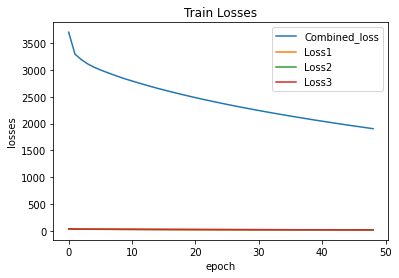

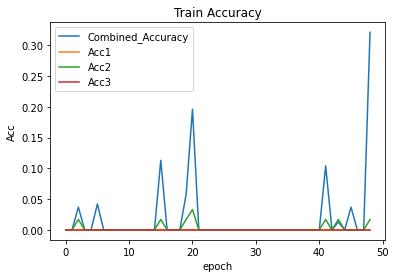

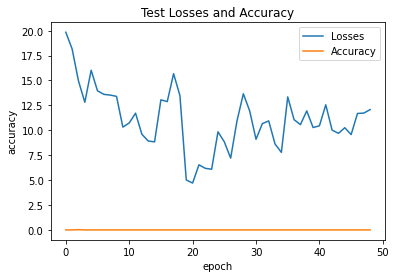

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0
train_accu = []
train_losses = []
train_accu1 = []
train_accu2 = []
train_accu3 = []
train_losses1 = []
train_losses2 = []
train_losses3 = []
val_accu = []
val_losses = []

print(len(train_loader))

CE = torch.nn.MSELoss()
ssim = PSNR()

def perceptual_loss(mask, pred):
    loss =  1.0 * CE(pred, mask)
    return loss

def perceptual_loss_detach(mask, pred):
    loss =  1.0 * CE(pred, mask.detach())
    return loss

def combine_loss(mask, pred):
    L1 = torch.nn.L1Loss()
    L2 = torch.nn.SmoothL1Loss()
    loss =  1.0 * ( L1(pred, mask) + L2(pred, mask))
    return loss

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    running_loss = 0
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    total = 0
    total1 = 0
    total2 = 0
    total3 = 0
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0

    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = ssim(gts, pre_res[0]) 
            loss2    = ssim(gts, pre_res[1])
            loss3    = ssim(gts, pre_res[2])
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data

            #loss graph
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            predicted1 = pre_res[0]
            predicted2 = pre_res[1]
            predicted3 = pre_res[2]
            total1 += gts.size(0)
            total2 += gts.size(1)
            total3 += gts.size(2)
            correct1 += float(torch.sum(predicted1 == gts.data))
            correct2 += float(torch.sum(predicted2 == gts.data))
            correct3 += float(torch.sum(predicted3 == gts.data))
            #correct1 += predicted1.eq(images).sum().item()
            #correct2 += predicted2.eq(gts).sum().item()
            #correct3 += predicted3.eq(depths).sum().item()

            running_loss += loss_all.item()
            gt, loss, predicted = pre_res
            outputs = torch.sum(gt + loss + predicted)
            total += images.size(0)
            correct += float(correct1 + correct2 + correct3)
            
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))

        train_loss = running_loss/len(train_loader)
        train_loss1=running_loss1/len(train_loader)
        train_loss2=running_loss2/len(train_loader)
        train_loss3=running_loss3/len(train_loader)
        accu1= correct1/total1
        accu2= correct2/total2
        accu3= correct3/total3 
        accu = correct/total
           
        train_accu1.append(round(accu1, 3))
        train_accu2.append(round(accu2, 3))
        train_accu3.append(round(accu3, 3))
        train_losses1.append(float(train_loss1))
        train_losses2.append(float(train_loss2))
        train_losses3.append(float(train_loss3))
        train_accu.append(round(accu, 3))
        train_losses.append(float(train_loss))

        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
           
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    running_loss = 0
    total = 0
    correct = 0.0

    correct1 = 0.0
    correct2 = 0.0
    correct3 = 0.0

    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])

            #loss graph
            running_loss += mae_sum.item()
            pre1, pre2, predicted = pre_res
            #outputs = float(torch.sum(gt + depth + predicted))
            total += test_loader.size

            #correct1 += float(torch.sum(pre1 == image.data))
            #correct2 += float(torch.sum(pre2 == image.data))
            #correct3 += float(torch.sum(predicted == image.data))

            correct += float(torch.sum(predicted == image.data))
            #correct += float(torch.sum(predicted == image).item())


        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
       
        val_loss=running_loss/len(test_loader)
        accu= 100 * correct/total
        val_accu.append(round(accu, 3))
        val_losses.append(float(val_loss))

        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                #torch.save(model.state_dict(), save_path+'SPNet_epoch_best_Combine_Loss_only_with_RGB_as_depth.pth')
                torch.save(model.state_dict(), save_path+'SPNet_text_output_graph.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)

plt.plot(train_losses, '-')
plt.plot(train_losses1,'-')
plt.plot(train_losses2,'-')
plt.plot(train_losses3,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_loss','Loss1', 'Loss2', 'Loss3'])
plt.title('Train Losses')
 
plt.show()

plt.plot(train_accu, '-')
plt.plot(train_accu1,'-')
plt.plot(train_accu2,'-')
plt.plot(train_accu3,'-')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(['Combined_Accuracy','Acc1', 'Acc2', 'Acc3'])
plt.title('Train Accuracy')
 
plt.show()

plt.plot(val_losses,'-')
plt.plot(val_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Losses','Accuracy'])
plt.title('Test Losses and Accuracy')
 
plt.show()

In [ ]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


USE GPU 0
load data...
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
SalObjDat
SalObjDataset ['/content/tmp/traindataset_only_depth/RGB/depth_00.png', '/content/tmp/traindataset_only_depth/RGB/depth_01.png', '/content/tmp/traindataset_only_depth/RGB/depth_02.png', '/content/tmp/traindataset_only_depth/RGB/depth_10.png', '/content/tmp/traindataset_only_depth/RGB/depth_100.png', '/content/tmp/traindataset_only_depth/RGB/depth_101.png', '/content/tmp/traindataset_only_depth/RGB/depth_102.png', '/content/tmp/traindataset_only_depth/RGB/depth_11.png', '/content/tmp/traindataset_only_depth/RGB/depth_110.png', '/content/tmp/traindataset_only_depth/RGB/depth_111.png', '/content/tmp/traindataset_only_depth/RGB/depth_112.png', '/content/tmp/traindataset_only_depth/RGB/depth_12.png', '/conten

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2022-07-03 19:57:09.833444 Epoch [001/050], Step [0001/0060], Loss1: 0.9875 Loss2: 0.9585 Loss3: 0.9715
2022-07-03 19:57:35.671219 Epoch [001/050], Step [0050/0060], Loss1: 0.8424 Loss2: 0.7166 Loss3: 0.7728
2022-07-03 19:57:40.925751 Epoch [001/050], Step [0060/0060], Loss1: 0.7724 Loss2: 0.5153 Loss3: 0.5672


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.6716934284835896 ####  bestMAE: 1 bestEpoch: 0
2022-07-03 19:57:46.646471 Epoch [002/050], Step [0001/0060], Loss1: 0.7601 Loss2: 0.5273 Loss3: 0.5366
2022-07-03 19:58:12.652358 Epoch [002/050], Step [0050/0060], Loss1: 0.6420 Loss2: 0.4726 Loss3: 0.4285
2022-07-03 19:58:17.930445 Epoch [002/050], Step [0060/0060], Loss1: 0.8073 Loss2: 0.5071 Loss3: 0.7408
Epoch: 2 MAE: 0.6503171640224559 ####  bestMAE: 0.6716934284835896 bestEpoch: 0
best epoch:2
2022-07-03 19:58:27.830867 Epoch [003/050], Step [0001/0060], Loss1: 0.7546 Loss2: 0.3726 Loss3: 0.5994
2022-07-03 19:58:54.656771 Epoch [003/050], Step [0050/0060], Loss1: 0.7288 Loss2: 0.2975 Loss3: 0.5153
2022-07-03 19:58:59.937942 Epoch [003/050], Step [0060/0060], Loss1: 0.7618 Loss2: 0.4599 Loss3: 0.6443
Epoch: 3 MAE: 0.6324983021569628 ####  bestMAE: 0.6503171640224559 bestEpoch: 2
best epoch:3
2022-07-03 19:59:08.289638 Epoch [004/050], Step [0001/0060], Loss1: 0.8172 Loss2: 0.6305 Loss3: 0.7096
2022-07-03 19:59:34.144

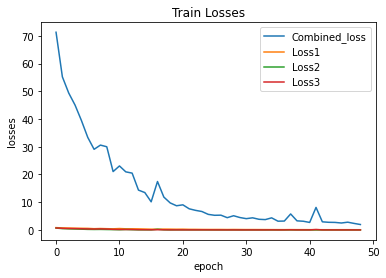

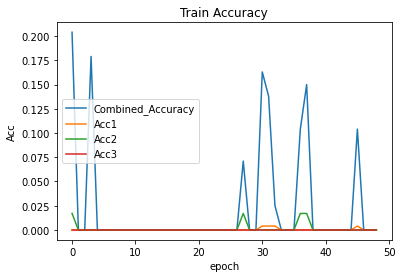

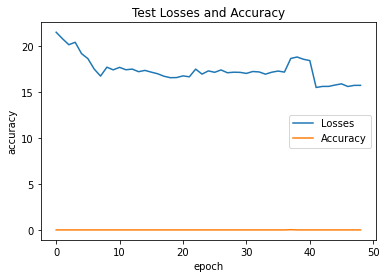

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0
train_accu = []
train_losses = []
train_accu1 = []
train_accu2 = []
train_accu3 = []
train_losses1 = []
train_losses2 = []
train_losses3 = []
val_accu = []
val_losses = []

print(len(train_loader))

CE = torch.nn.MSELoss()

def perceptual_loss(mask, pred):
    loss =  1.0 * CE(pred, mask)
    return loss

def perceptual_loss_detach(mask, pred):
    loss =  1.0 * CE(pred, mask.detach())
    return loss

def combine_loss(mask, pred):
    L1 = torch.nn.L1Loss()
    L2 = torch.nn.SmoothL1Loss()
    loss =  1.0 * ( L1(pred, mask) + L2(pred, mask))
    return loss

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    running_loss = 0
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    total = 0
    total1 = 0
    total2 = 0
    total3 = 0
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0

    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = ms_ssim( gts, pre_res[0], data_range=255, size_average=True)
            loss2    = ms_ssim(gts, pre_res[1], data_range=255, size_average=True)
            loss3    = ms_ssim(gts, pre_res[2], data_range=255, size_average=True)
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.mean().backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data

            #loss graph
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            predicted1 = pre_res[0]
            predicted2 = pre_res[1]
            predicted3 = pre_res[2]
            total1 += gts.size(0)
            total2 += gts.size(1)
            total3 += gts.size(2)
            correct1 += float(torch.sum(predicted1 == gts.data))
            correct2 += float(torch.sum(predicted2 == gts.data))
            correct3 += float(torch.sum(predicted3 == gts.data))
            #correct1 += predicted1.eq(images).sum().item()
            #correct2 += predicted2.eq(gts).sum().item()
            #correct3 += predicted3.eq(depths).sum().item()

            running_loss += loss_all.item()
            gt, loss, predicted = pre_res
            outputs = torch.sum(gt + loss + predicted)
            total += images.size(0)
            correct += float(correct1 + correct2 + correct3)
            
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))

        train_loss = running_loss/len(train_loader)
        train_loss1=running_loss1/len(train_loader)
        train_loss2=running_loss2/len(train_loader)
        train_loss3=running_loss3/len(train_loader)
        accu1= correct1/total1
        accu2= correct2/total2
        accu3= correct3/total3 
        accu = correct/total
           
        train_accu1.append(round(accu1, 3))
        train_accu2.append(round(accu2, 3))
        train_accu3.append(round(accu3, 3))
        train_losses1.append(float(train_loss1))
        train_losses2.append(float(train_loss2))
        train_losses3.append(float(train_loss3))
        train_accu.append(round(accu, 3))
        train_losses.append(float(train_loss))

        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
           
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    running_loss = 0
    total = 0
    correct = 0.0

    correct1 = 0.0
    correct2 = 0.0
    correct3 = 0.0

    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])

            #loss graph
            running_loss += mae_sum.item()
            pre1, pre2, predicted = pre_res
            #outputs = float(torch.sum(gt + depth + predicted))
            total += test_loader.size

            #correct1 += float(torch.sum(pre1 == image.data))
            #correct2 += float(torch.sum(pre2 == image.data))
            #correct3 += float(torch.sum(predicted == image.data))

            correct += float(torch.sum(predicted == image.data))
            #correct += float(torch.sum(predicted == image).item())


        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
       
        val_loss=running_loss/len(test_loader)
        accu= 100 * correct/total
        val_accu.append(round(accu, 3))
        val_losses.append(float(val_loss))

        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                #torch.save(model.state_dict(), save_path+'SPNet_epoch_best_Combine_Loss_only_with_RGB_as_depth.pth')
                torch.save(model.state_dict(), save_path+'SPNet_text_output_graph.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)

plt.plot(train_losses, '-')
plt.plot(train_losses1,'-')
plt.plot(train_losses2,'-')
plt.plot(train_losses3,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_loss','Loss1', 'Loss2', 'Loss3'])
plt.title('Train Losses')
 
plt.show()

plt.plot(train_accu, '-')
plt.plot(train_accu1,'-')
plt.plot(train_accu2,'-')
plt.plot(train_accu3,'-')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(['Combined_Accuracy','Acc1', 'Acc2', 'Acc3'])
plt.title('Train Accuracy')
 
plt.show()

plt.plot(val_losses,'-')
plt.plot(val_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Losses','Accuracy'])
plt.title('Test Losses and Accuracy')
 
plt.show()

In [ ]:
!pip install git+https://github.com/pytorch/pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/pytorch.git to /tmp/pip-req-build-029alv_4
  Running command git clone -q https://github.com/pytorch/pytorch.git /tmp/pip-req-build-029alv_4
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... canceledERROR: Operation cancelled by user


In [ ]:
!pip install piq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


USE GPU 0
load data...
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
SalObjDat
SalObjDataset ['/content/tmp/traindataset_only_depth/RGB/depth_00.png', '/content/tmp/traindataset_only_depth/RGB/depth_01.png', '/content/tmp/traindataset_only_depth/RGB/depth_02.png', '/content/tmp/traindataset_only_depth/RGB/depth_10.png', '/content/tmp/traindataset_only_depth/RGB/depth_100.png', '/content/tmp/traindataset_only_depth/RGB/depth_101.png', '/content/tmp/traindataset_only_depth/RGB/depth_102.png', '/content/tmp/traindataset_only_depth/RGB/depth_11.png', '/content/tmp/traindataset_only_depth/RGB/depth_110.png', '/content/tmp/traindataset_only_depth/RGB/depth_111.png', '/content/tmp/traindataset_only_depth/RGB/depth_112.png', '/content/tmp/traindataset_only_depth/RGB/depth_12.png', '/conten

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Start train...
2022-07-03 21:40:57.956979 Epoch [001/050], Step [0001/0060], Loss1: 0.6784 Loss2: 0.6355 Loss3: 0.6483
2022-07-03 21:41:39.620314 Epoch [001/050], Step [0050/0060], Loss1: 0.3825 Loss2: 0.4320 Loss3: 0.3618
2022-07-03 21:41:48.037919 Epoch [001/050], Step [0060/0060], Loss1: 0.3634 Loss2: 0.4071 Loss3: 0.3374


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.2610295906268731 ####  bestMAE: 1 bestEpoch: 0
2022-07-03 21:41:54.654907 Epoch [002/050], Step [0001/0060], Loss1: 0.3468 Loss2: 0.4148 Loss3: 0.3259
2022-07-03 21:42:36.042344 Epoch [002/050], Step [0050/0060], Loss1: 0.2598 Loss2: 0.3260 Loss3: 0.2094
2022-07-03 21:42:44.633823 Epoch [002/050], Step [0060/0060], Loss1: 0.2499 Loss2: 0.3276 Loss3: 0.2183
Epoch: 2 MAE: 0.35873245743847393 ####  bestMAE: 0.2610295906268731 bestEpoch: 0
2022-07-03 21:42:51.238494 Epoch [003/050], Step [0001/0060], Loss1: 0.2563 Loss2: 0.3285 Loss3: 0.2133
2022-07-03 21:43:32.815862 Epoch [003/050], Step [0050/0060], Loss1: 0.2271 Loss2: 0.2862 Loss3: 0.1720
2022-07-03 21:43:41.237981 Epoch [003/050], Step [0060/0060], Loss1: 0.2080 Loss2: 0.2727 Loss3: 0.1575
Epoch: 3 MAE: 0.463875329456632 ####  bestMAE: 0.2610295906268731 bestEpoch: 0
2022-07-03 21:43:47.861527 Epoch [004/050], Step [0001/0060], Loss1: 0.2201 Loss2: 0.2824 Loss3: 0.1729
2022-07-03 21:44:29.111155 Epoch [004/050], Step 

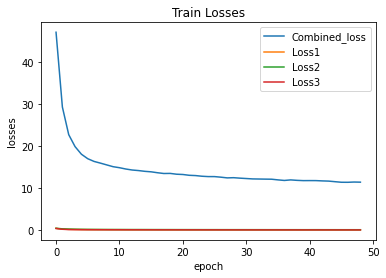

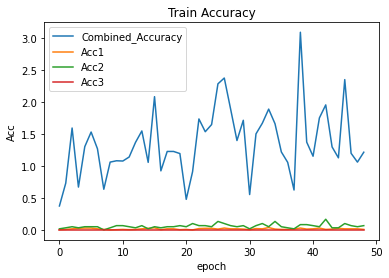

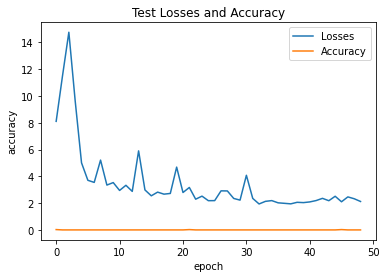

In [ ]:
from torch._C import device
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from piq import LPIPS

#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0
train_accu = []
train_losses = []
train_accu1 = []
train_accu2 = []
train_accu3 = []
train_losses1 = []
train_losses2 = []
train_losses3 = []
val_accu = []
val_losses = []

print(len(train_loader))

CE = torch.nn.MSELoss()
loss_fn_alex = LPIPS(replace_pooling = True, distance ='mse', reduction= 'mean', std= [0.229, 0.224, 0.225])

def perceptual_loss(mask, pred):
    loss =  1.0 * CE(pred, mask)
    return loss

def perceptual_loss_detach(mask, pred):
    loss =  1.0 * CE(pred, mask.detach())
    return loss

def combine_loss(mask, pred):
    L1 = torch.nn.L1Loss()
    L2 = torch.nn.SmoothL1Loss()
    loss =  1.0 * ( L1(pred, mask) + L2(pred, mask))
    return loss

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    running_loss = 0
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    total = 0
    total1 = 0
    total2 = 0
    total3 = 0
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0

    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            #loss1    = ms_ssim( gts, pre_res[0], data_range=255, size_average=True)
            #loss2    = ms_ssim(gts, pre_res[1], data_range=255, size_average=True)
            #loss3    = ms_ssim(gts, pre_res[2], data_range=255, size_average=True)
            device = torch.device("cuda:0")

            loss1 = loss_fn_alex(gts, pre_res[0])
            loss2 = loss_fn_alex(gts, pre_res[1])
            loss3 = loss_fn_alex(gts, pre_res[2])
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.mean().backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data

            #loss graph
            running_loss1 += loss1.data
            running_loss2 += loss2.data
            running_loss3 += loss3.data
            predicted1 = pre_res[0]
            predicted2 = pre_res[1]
            predicted3 = pre_res[2]
            total1 += gts.size(0)
            total2 += gts.size(1)
            total3 += gts.size(2)
            correct1 += float(torch.sum(predicted1 == gts.data))
            correct2 += float(torch.sum(predicted2 == gts.data))
            correct3 += float(torch.sum(predicted3 == gts.data))
            #correct1 += predicted1.eq(images).sum().item()
            #correct2 += predicted2.eq(gts).sum().item()
            #correct3 += predicted3.eq(depths).sum().item()

            running_loss += loss_all
            gt, loss, predicted = pre_res
            outputs = torch.sum(gt + loss + predicted)
            total += images.size(0)
            correct += float(correct1 + correct2 + correct3)
            
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))

        train_loss = running_loss/len(train_loader)
        train_loss1=running_loss1/len(train_loader)
        train_loss2=running_loss2/len(train_loader)
        train_loss3=running_loss3/len(train_loader)
        accu1= correct1/total1
        accu2= correct2/total2
        accu3= correct3/total3 
        accu = correct/total
           
        train_accu1.append(round(accu1, 3))
        train_accu2.append(round(accu2, 3))
        train_accu3.append(round(accu3, 3))
        train_losses1.append(float(train_loss1))
        train_losses2.append(float(train_loss2))
        train_losses3.append(float(train_loss3))
        train_accu.append(round(accu, 3))
        train_losses.append(float(train_loss))

        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
           
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    running_loss = 0
    total = 0
    correct = 0.0

    correct1 = 0.0
    correct2 = 0.0
    correct3 = 0.0

    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])
            #loss graph
            running_loss += mae_sum.item()
            pre1, pre2, predicted = pre_res
            #outputs = float(torch.sum(gt + depth + predicted))
            total += test_loader.size

            #correct1 += float(torch.sum(pre1 == image.data))
            #correct2 += float(torch.sum(pre2 == image.data))
            #correct3 += float(torch.sum(predicted == image.data))

            correct += float(torch.sum(predicted == image.data))
            #correct += float(torch.sum(predicted == image).item())


        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
       
        val_loss=running_loss/len(test_loader)
        accu= 100 * correct/total
        val_accu.append(round(accu, 3))
        val_losses.append(float(val_loss))

        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                #torch.save(model.state_dict(), save_path+'SPNet_epoch_best_Combine_Loss_only_with_RGB_as_depth.pth')
                torch.save(model.state_dict(), save_path+'SPNet_text_output_graph.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)

plt.plot(train_losses, '-')
plt.plot(train_losses1,'-')
plt.plot(train_losses2,'-')
plt.plot(train_losses3,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_loss','Loss1', 'Loss2', 'Loss3'])
plt.title('Train Losses')
 
plt.show()

plt.plot(train_accu, '-')
plt.plot(train_accu1,'-')
plt.plot(train_accu2,'-')
plt.plot(train_accu3,'-')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(['Combined_Accuracy','Acc1', 'Acc2', 'Acc3'])
plt.title('Train Accuracy')
 
plt.show()

plt.plot(val_losses,'-')
plt.plot(val_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Losses','Accuracy'])
plt.title('Test Losses and Accuracy')
 
plt.show()

#Train Model

#Combine Loss 100 epoches

USE GPU 0


Downloading: "https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth" to /root/.cache/torch/hub/checkpoints/res2net50_v1b_26w_4s-3cf99910.pth


  0%|          | 0.00/98.4M [00:00<?, ?B/s]

load data...
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
SalObjDat
SalObjDataset ['/content/tmp/traindataset_only_depth/RGB/depth_00.png', '/content/tmp/traindataset_only_depth/RGB/depth_01.png', '/content/tmp/traindataset_only_depth/RGB/depth_02.png', '/content/tmp/traindataset_only_depth/RGB/depth_10.png', '/content/tmp/traindataset_only_depth/RGB/depth_100.png', '/content/tmp/traindataset_only_depth/RGB/depth_101.png', '/content/tmp/traindataset_only_depth/RGB/depth_102.png', '/content/tmp/traindataset_only_depth/RGB/depth_11.png', '/content/tmp/traindataset_only_depth/RGB/depth_110.png', '/content/tmp/traindataset_only_depth/RGB/depth_111.png', '/content/tmp/traindataset_only_depth/RGB/depth_112.png', '/content/tmp/traindataset_only_depth/RGB/depth_12.png', '/content/tmp/trai

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


60
Start train...
2022-06-19 21:24:22.208757 Epoch [001/100], Step [0001/0060], Loss1: 0.5368 Loss2: 1.1359 Loss3: 0.5247
2022-06-19 21:24:46.919346 Epoch [001/100], Step [0050/0060], Loss1: 0.1232 Loss2: 0.0960 Loss3: 0.1089
2022-06-19 21:24:51.949978 Epoch [001/100], Step [0060/0060], Loss1: 0.0995 Loss2: 0.0962 Loss3: 0.0817


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.23950264138519436 ####  bestMAE: 1 bestEpoch: 0
2022-06-19 21:25:01.049175 Epoch [002/100], Step [0001/0060], Loss1: 0.1020 Loss2: 0.0895 Loss3: 0.0858
2022-06-19 21:25:25.735055 Epoch [002/100], Step [0050/0060], Loss1: 0.0707 Loss2: 0.0711 Loss3: 0.0698
2022-06-19 21:25:30.766012 Epoch [002/100], Step [0060/0060], Loss1: 0.0708 Loss2: 0.0672 Loss3: 0.0585
Epoch: 2 MAE: 0.23674373767994072 ####  bestMAE: 0.23950264138519436 bestEpoch: 0
best epoch:2
2022-06-19 21:25:38.449922 Epoch [003/100], Step [0001/0060], Loss1: 0.0900 Loss2: 0.1063 Loss3: 0.1013
2022-06-19 21:26:03.350183 Epoch [003/100], Step [0050/0060], Loss1: 0.0833 Loss2: 0.0730 Loss3: 0.0744
2022-06-19 21:26:08.379935 Epoch [003/100], Step [0060/0060], Loss1: 0.0581 Loss2: 0.0678 Loss3: 0.0522
Epoch: 3 MAE: 0.14279665992373514 ####  bestMAE: 0.23674373767994072 bestEpoch: 2
best epoch:3
2022-06-19 21:26:16.271907 Epoch [004/100], Step [0001/0060], Loss1: 0.0717 Loss2: 0.0660 Loss3: 0.0492
2022-06-19 21:26:4

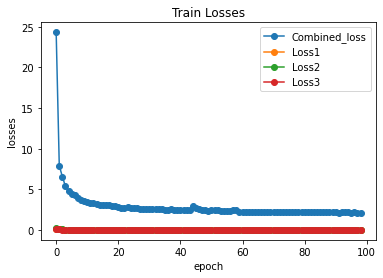

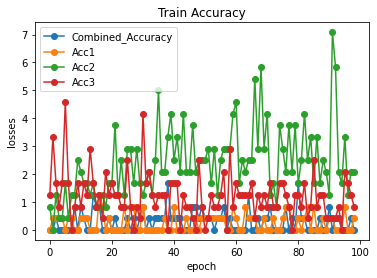

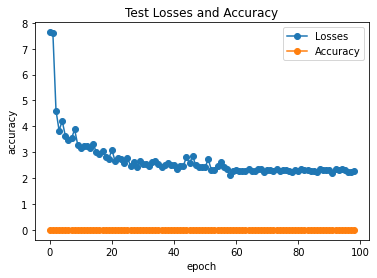

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0
train_accu = []
train_losses = []
train_accu1 = []
train_accu2 = []
train_accu3 = []
train_losses1 = []
train_losses2 = []
train_losses3 = []
val_accu = []
val_losses = []

print(len(train_loader))

CE = torch.nn.MSELoss()

def perceptual_loss(mask, pred):
    loss =  1.0 * CE(pred, mask)
    return loss

def perceptual_loss_detach(mask, pred):
    loss =  1.0 * CE(pred, mask.detach())
    return loss

def combine_loss(mask, pred):
    L1 = torch.nn.L1Loss()
    L2 = torch.nn.SmoothL1Loss()
    loss =  1.0 * ( L1(pred, mask) + L2(pred, mask))
    return loss

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    running_loss = 0
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    total = 0
    total1 = 0
    total2 = 0
    total3 = 0
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0

    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = combine_loss(gts, pre_res[0]) 
            loss2    = combine_loss(gts, pre_res[1])
            loss3    = combine_loss(gts, pre_res[2])
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data

            #loss graph
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            predicted1 = pre_res[0]
            predicted2 = pre_res[1]
            predicted3 = pre_res[2]
            total1 += images.size(0)
            total2 += gts.size(0)
            total3 += depths.size(0)
            correct1 += predicted1.eq(images).sum().item()
            correct2 += predicted2.eq(gts).sum().item()
            correct3 += predicted3.eq(depths).sum().item()

            running_loss += loss_all.item()
            gt, loss, predicted = pre_res
            outputs = gt + loss + predicted
            total += images.size(0)
            correct += outputs.eq(images).sum().item()
            
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))

        train_loss = running_loss/len(train_loader)
        train_loss1=running_loss1/len(train_loader)
        train_loss2=running_loss2/len(train_loader)
        train_loss3=running_loss3/len(train_loader)
        accu = 100.*correct/total
        accu1=100.*correct1/total1
        accu2=100.*correct2/total2
        accu3=100.*correct3/total3        
        train_accu1.append(accu1)
        train_accu2.append(accu2)
        train_accu3.append(accu3)
        train_losses1.append(train_loss1)
        train_losses2.append(train_loss2)
        train_losses3.append(train_loss3)
        train_accu.append(accu)
        train_losses.append(train_loss)

        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
           
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    running_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])

            #loss graph
            running_loss += mae_sum.item()
            gt, loss, predicted = pre_res
            outputs = gt + loss + predicted
            total += test_loader.size
            correct += outputs.eq(image).sum().item()


        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
       
        val_loss=running_loss/len(test_loader)
        accu=100.*correct/total
        val_accu.append(accu)
        val_losses.append(val_loss)

        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                torch.save(model.state_dict(), save_path+'SPNet_epoch_best_Combine_Loss_only_with_RGB_as_depth.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)

plt.plot(train_losses, '-o')
plt.plot(train_losses1,'-o')
plt.plot(train_losses2,'-o')
plt.plot(train_losses3,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_loss','Loss1', 'Loss2', 'Loss3'])
plt.title('Train Losses')
 
plt.show()

plt.plot(train_accu, '-o')
plt.plot(train_accu1,'-o')
plt.plot(train_accu2,'-o')
plt.plot(train_accu3,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_Accuracy','Acc1', 'Acc2', 'Acc3'])
plt.title('Train Accuracy')
 
plt.show()

plt.plot(val_losses,'-o')
plt.plot(val_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Losses','Accuracy'])
plt.title('Test Losses and Accuracy')
 
plt.show()

# SSIM Loss Epoch 100

USE GPU 0


Downloading: "https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth" to /root/.cache/torch/hub/checkpoints/res2net50_v1b_26w_4s-3cf99910.pth


  0%|          | 0.00/98.4M [00:00<?, ?B/s]

load data...
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
/content/tmp/traindataset_only_depth/RGB/ /content/tmp/traindataset_only_depth/GT/ /content/tmp/traindataset_only_depth/depth/
SalObjDat
SalObjDataset ['/content/tmp/traindataset_only_depth/RGB/depth_00.png', '/content/tmp/traindataset_only_depth/RGB/depth_01.png', '/content/tmp/traindataset_only_depth/RGB/depth_02.png', '/content/tmp/traindataset_only_depth/RGB/depth_10.png', '/content/tmp/traindataset_only_depth/RGB/depth_100.png', '/content/tmp/traindataset_only_depth/RGB/depth_101.png', '/content/tmp/traindataset_only_depth/RGB/depth_102.png', '/content/tmp/traindataset_only_depth/RGB/depth_11.png', '/content/tmp/traindataset_only_depth/RGB/depth_110.png', '/content/tmp/traindataset_only_depth/RGB/depth_111.png', '/content/tmp/traindataset_only_depth/RGB/depth_112.png', '/content/tmp/traindataset_only_depth/RGB/depth_12.png', '/content/tmp/trai

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


60
Start train...
2022-06-21 18:23:18.737133 Epoch [001/500], Step [0001/0060], Loss1: -0.0706 Loss2: 0.1981 Loss3: -0.0291
2022-06-21 18:23:54.862364 Epoch [001/500], Step [0050/0060], Loss1: -0.8758 Loss2: -0.9119 Loss3: -0.9182
2022-06-21 18:24:02.370517 Epoch [001/500], Step [0060/0060], Loss1: -0.9151 Loss2: -0.9179 Loss3: -0.9463


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.20140315383830398 ####  bestMAE: 1 bestEpoch: 0
2022-06-21 18:24:12.171402 Epoch [002/500], Step [0001/0060], Loss1: -0.8883 Loss2: -0.9041 Loss3: -0.9351
2022-06-21 18:24:49.961930 Epoch [002/500], Step [0050/0060], Loss1: -0.9260 Loss2: -0.9424 Loss3: -0.9541
2022-06-21 18:24:57.832539 Epoch [002/500], Step [0060/0060], Loss1: -0.9360 Loss2: -0.9466 Loss3: -0.9614
Epoch: 2 MAE: 0.16691753972775086 ####  bestMAE: 0.20140315383830398 bestEpoch: 0
best epoch:2
2022-06-21 18:25:06.721924 Epoch [003/500], Step [0001/0060], Loss1: -0.9415 Loss2: -0.9392 Loss3: -0.9663
2022-06-21 18:25:45.009834 Epoch [003/500], Step [0050/0060], Loss1: -0.9516 Loss2: -0.9495 Loss3: -0.9687
2022-06-21 18:25:52.775520 Epoch [003/500], Step [0060/0060], Loss1: -0.9179 Loss2: -0.9267 Loss3: -0.9459
Epoch: 3 MAE: 0.1406693134610615 ####  bestMAE: 0.16691753972775086 bestEpoch: 2
best epoch:3
2022-06-21 18:26:01.707352 Epoch [004/500], Step [0001/0060], Loss1: -0.9443 Loss2: -0.9497 Loss3: -0.961

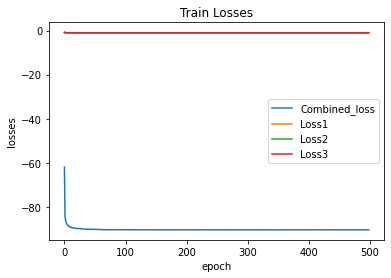

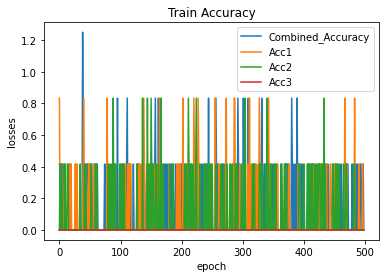

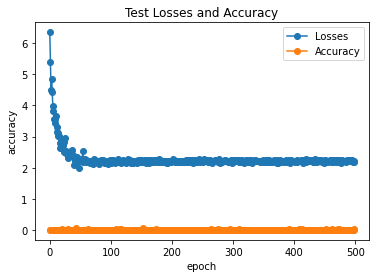

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0
train_accu = []
train_losses = []
train_accu1 = []
train_accu2 = []
train_accu3 = []
train_losses1 = []
train_losses2 = []
train_losses3 = []
val_accu = []
val_losses = []

print(len(train_loader))

def perceptual_loss(mask, pred):
    loss =  1.0 * CE(pred, mask)
    return loss

def perceptual_loss_detach(mask, pred):
    loss =  1.0 * CE(pred, mask.detach())
    return loss

def combine_loss(mask, pred):
    L1 = torch.nn.L1Loss()
    L2 = torch.nn.SmoothL1Loss()
    loss =  1.0 * ( L1(pred, mask) + L2(pred, mask))
    return loss

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    running_loss = 0
    running_loss1 = 0
    running_loss2 = 0
    running_loss3 = 0
    total = 0
    total1 = 0
    total2 = 0
    total3 = 0
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0

    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = fun_ssim(gts, pre_res[0]) 
            loss2    = fun_ssim(gts, pre_res[1])
            loss3    = fun_ssim(gts, pre_res[2])
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()
            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data

            #loss graph
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            running_loss3 += loss3.item()
            predicted1 = pre_res[0]
            predicted2 = pre_res[1]
            predicted3 = pre_res[2]
            total1 += images.size(0)
            total2 += gts.size(0)
            total3 += depths.size(0)
            correct1 += predicted1.eq(images).sum().item()
            correct2 += predicted2.eq(gts).sum().item()
            correct3 += predicted3.eq(depths).sum().item()

            running_loss += loss_all.item()
            gt, loss, predicted = pre_res
            outputs = gt + loss + predicted
            total += images.size(0)
            correct += outputs.eq(images).sum().item()
            
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))

        train_loss = running_loss/len(train_loader)
        train_loss1=running_loss1/len(train_loader)
        train_loss2=running_loss2/len(train_loader)
        train_loss3=running_loss3/len(train_loader)
        accu = 100.*correct/total
        accu1=100.*correct1/total1
        accu2=100.*correct2/total2
        accu3=100.*correct3/total3        
        train_accu1.append(accu1)
        train_accu2.append(accu2)
        train_accu3.append(accu3)
        train_losses1.append(train_loss1)
        train_losses2.append(train_loss2)
        train_losses3.append(train_loss3)
        train_accu.append(accu)
        train_losses.append(train_loss)

        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
           
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    running_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])

            #loss graph
            running_loss += mae_sum.item()
            gt, loss, predicted = pre_res
            outputs = gt + loss + predicted
            total += test_loader.size
            correct += outputs.eq(image).sum().item()


        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
       
        val_loss=running_loss/len(test_loader)
        accu=100.*correct/total
        val_accu.append(accu)
        val_losses.append(val_loss)

        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                torch.save(model.state_dict(), save_path+'SPNet_epoch_SSIM_Loss_500_RGB_as_depth.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)

plt.plot(train_losses, '-')
plt.plot(train_losses1,'-')
plt.plot(train_losses2,'-')
plt.plot(train_losses3,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_loss','Loss1', 'Loss2', 'Loss3'])
plt.title('Train Losses')
 
plt.show()

plt.plot(train_accu, '-')
plt.plot(train_accu1,'-')
plt.plot(train_accu2,'-')
plt.plot(train_accu3,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Combined_Accuracy','Acc1', 'Acc2', 'Acc3'])
plt.title('Train Accuracy')
 
plt.show()

plt.plot(val_losses,'-o')
plt.plot(val_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Losses','Accuracy'])
plt.title('Test Losses and Accuracy')
 
plt.show()

#MSE Loss

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn


#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

#set loss function
CE   = torch.nn.MSELoss()

step = 0
writer     = SummaryWriter(save_path+'summary')
best_mae   = 1
best_epoch = 0

print(len(train_loader))


def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def perceptual_loss(pred, mask):
    loss = torch.nn.functional.l1_loss(pred, mask)
    return loss

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = CE(pre_res[0], gts) 
            loss2    = CE(pre_res[1], gts)
            loss3    = CE(pre_res[2], gts) 
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()

            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))
                
        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch))
            
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])
        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                torch.save(model.state_dict(), save_path+'SPNet_epoch_best_MSE_Loss_update_with_Adam.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)


USE GPU 0


Downloading: "https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth" to /root/.cache/torch/hub/checkpoints/res2net50_v1b_26w_4s-3cf99910.pth


  0%|          | 0.00/98.4M [00:00<?, ?B/s]

load data...
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
SalObjDat
SalObjDataset ['/content/tmp/TrainDataset_update/RGB/RGB_00.png', '/content/tmp/TrainDataset_update/RGB/RGB_01.png', '/content/tmp/TrainDataset_update/RGB/RGB_02.png', '/content/tmp/TrainDataset_update/RGB/RGB_10.png', '/content/tmp/TrainDataset_update/RGB/RGB_100.png', '/content/tmp/TrainDataset_update/RGB/RGB_101.png', '/content/tmp/TrainDataset_update/RGB/RGB_102.png', '/content/tmp/TrainDataset_update/RGB/RGB_11.png', '/content/tmp/TrainDataset_update/RGB/RGB_110.png', '/content/tmp/TrainDataset_update/RGB/RGB_111.png', '/content/tmp/TrainDataset_update/RGB/RGB_112.png', '/content/tmp/TrainDataset_update/RGB/RGB_12.png', '/content/tmp/TrainDataset_update/RGB/RGB_120.png', '/content/tmp/TrainDataset_update/RGB/RGB_121.png', '/content/

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


60
Start train...
2022-06-09 18:47:34.722714 Epoch [001/030], Step [0001/0060], Loss1: 0.3909 Loss2: 0.2552 Loss3: 0.8783
2022-06-09 18:48:02.234132 Epoch [001/030], Step [0050/0060], Loss1: 0.0278 Loss2: 0.0169 Loss3: 0.0153
2022-06-09 18:48:07.775465 Epoch [001/030], Step [0060/0060], Loss1: 0.0228 Loss2: 0.0110 Loss3: 0.0086


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.3358296906001985 ####  bestMAE: 1 bestEpoch: 0
2022-06-09 18:48:18.758026 Epoch [002/030], Step [0001/0060], Loss1: 0.0212 Loss2: 0.0122 Loss3: 0.0095
2022-06-09 18:48:46.062448 Epoch [002/030], Step [0050/0060], Loss1: 0.0181 Loss2: 0.0083 Loss3: 0.0077
2022-06-09 18:48:51.609186 Epoch [002/030], Step [0060/0060], Loss1: 0.0212 Loss2: 0.0084 Loss3: 0.0077
Epoch: 2 MAE: 0.3004963377291564 ####  bestMAE: 0.3358296906001985 bestEpoch: 0
best epoch:2
2022-06-09 18:49:08.158854 Epoch [003/030], Step [0001/0060], Loss1: 0.0170 Loss2: 0.0090 Loss3: 0.0089
2022-06-09 18:49:36.445724 Epoch [003/030], Step [0050/0060], Loss1: 0.0117 Loss2: 0.0060 Loss3: 0.0059
2022-06-09 18:49:41.972051 Epoch [003/030], Step [0060/0060], Loss1: 0.0124 Loss2: 0.0064 Loss3: 0.0057
Epoch: 3 MAE: 0.2545958770267548 ####  bestMAE: 0.3004963377291564 bestEpoch: 2
best epoch:3
2022-06-09 18:49:51.962349 Epoch [004/030], Step [0001/0060], Loss1: 0.0111 Loss2: 0.0054 Loss3: 0.0048
2022-06-09 18:50:20.383

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn


#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

#set loss function
CE   = torch.nn.MSELoss()

step = 0
writer     = SummaryWriter(save_path+'summary_SSIM')
best_mae   = 1
best_epoch = 0

print(len(train_loader))


def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def perceptual_loss(pred, mask):
    loss = torch.nn.functional.l1_loss(pred, mask)
    return loss

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = fun_ssim(pre_res[0], gts) 
            loss2    = fun_ssim(pre_res[1], gts)
            loss3    = fun_ssim(pre_res[2], gts) 
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()

            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))
                
        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_SSIM_epoch_{}.pth'.format(epoch))
            
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_SSIM_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])
        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                torch.save(model.state_dict(), save_path+'SPNet_epoch_best_SSIM_Loss_updated_with_Adam.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)


USE GPU 0
load data...
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
SalObjDat
SalObjDataset ['/content/tmp/TrainDataset_update/RGB/RGB_00.png', '/content/tmp/TrainDataset_update/RGB/RGB_01.png', '/content/tmp/TrainDataset_update/RGB/RGB_02.png', '/content/tmp/TrainDataset_update/RGB/RGB_10.png', '/content/tmp/TrainDataset_update/RGB/RGB_100.png', '/content/tmp/TrainDataset_update/RGB/RGB_101.png', '/content/tmp/TrainDataset_update/RGB/RGB_102.png', '/content/tmp/TrainDataset_update/RGB/RGB_11.png', '/content/tmp/TrainDataset_update/RGB/RGB_110.png', '/content/tmp/TrainDataset_update/RGB/RGB_111.png', '/content/tmp/TrainDataset_update/RGB/RGB_112.png', '/content/tmp/TrainDataset_update/RGB/RGB_12.png', '/content/tmp/TrainDataset_update/RGB/RGB_120.png', '/content/tmp/TrainDataset_update/RGB/RGB_121.png', 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2022-06-06 18:23:43.639961 Epoch [001/030], Step [0001/0060], Loss1: -0.0496 Loss2: 0.0130 Loss3: 0.0754
2022-06-06 18:24:22.265198 Epoch [001/030], Step [0050/0060], Loss1: -0.8543 Loss2: -0.8975 Loss3: -0.9119
2022-06-06 18:24:30.113308 Epoch [001/030], Step [0060/0060], Loss1: -0.7385 Loss2: -0.8107 Loss3: -0.8660


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.219527400385135 ####  bestMAE: 1 bestEpoch: 0
2022-06-06 18:24:37.034086 Epoch [002/030], Step [0001/0060], Loss1: -0.8892 Loss2: -0.9303 Loss3: -0.9332
2022-06-06 18:25:15.101292 Epoch [002/030], Step [0050/0060], Loss1: -0.9298 Loss2: -0.9524 Loss3: -0.9623
2022-06-06 18:25:22.887493 Epoch [002/030], Step [0060/0060], Loss1: -0.9111 Loss2: -0.9525 Loss3: -0.9556
Epoch: 2 MAE: 0.17134729173448346 ####  bestMAE: 0.219527400385135 bestEpoch: 0
best epoch:2
2022-06-06 18:25:32.671598 Epoch [003/030], Step [0001/0060], Loss1: -0.9437 Loss2: -0.9651 Loss3: -0.9700
2022-06-06 18:26:11.290706 Epoch [003/030], Step [0050/0060], Loss1: -0.8988 Loss2: -0.9470 Loss3: -0.9573
2022-06-06 18:26:19.104971 Epoch [003/030], Step [0060/0060], Loss1: -0.8947 Loss2: -0.9413 Loss3: -0.9660
Epoch: 3 MAE: 0.16027139562778372 ####  bestMAE: 0.17134729173448346 bestEpoch: 2
best epoch:3
2022-06-06 18:26:28.611058 Epoch [004/030], Step [0001/0060], Loss1: -0.9546 Loss2: -0.9647 Loss3: -0.9755
2

In [ ]:
import os
import torch
import torch.nn.functional as F
import sys
import numpy as np
from datetime import datetime
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import logging
import torch.backends.cudnn as cudnn


#set the device for training
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')

  
cudnn.benchmark = True

#build the model
model = SPNet(32,50)
if(opt.load is not None):
    model.load_state_dict(torch.load(opt.load))
    print('load model from ',opt.load)

torch.cuda.empty_cache()
if torch.cuda.is_available():  
  model.cuda()
params    = model.parameters()
optimizer = torch.optim.Adam(params, opt.lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#set the path
train_image_root = opt.rgb_label_root
train_gt_root    = opt.gt_label_root
train_depth_root = opt.depth_label_root

val_image_root   = opt.val_rgb_root
val_gt_root      = opt.val_gt_root
val_depth_root   = opt.val_depth_root
save_path        = opt.save_path


if not os.path.exists(save_path):
    os.makedirs(save_path)

#load data
print('load data...')
print(train_image_root, train_gt_root, train_depth_root)
train_loader = get_loader(train_image_root, train_gt_root,train_depth_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
test_loader  = test_dataset(val_image_root, val_gt_root,val_depth_root, opt.trainsize)
total_step   = len(train_loader)


logging.basicConfig(filename=save_path+'log.log',format='[%(asctime)s-%(filename)s-%(levelname)s:%(message)s]', level = logging.INFO,filemode='a',datefmt='%Y-%m-%d %I:%M:%S %p')
logging.info("BBSNet_unif-Train")
logging.info("Config")
logging.info('epoch:{};lr:{};batchsize:{};trainsize:{};clip:{};decay_rate:{};load:{};save_path:{};decay_epoch:{}'.format(opt.epoch,opt.lr,opt.batchsize,opt.trainsize,opt.clip,opt.decay_rate,opt.load,save_path,opt.decay_epoch))

#set loss function
CE   = torch.nn.L1Loss()

step = 0
writer     = SummaryWriter(save_path+'summary_Org')
best_mae   = 1
best_epoch = 0

def structure_loss(pred, mask):
    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)
    return (wbce+wiou).mean()

def perceptual_loss(pred, mask):
    loss = torch.nn.functional.l1_loss(pred, mask)
    return loss

def train(train_loader, model, optimizer, epoch,save_path):
    global step
    model.train()
    loss_all=0
    epoch_step=0
    try:
        for i, (images, gts, depths) in enumerate(train_loader, start=1):
            optimizer.zero_grad()
            if torch.cuda.is_available():
              images   = images.cuda()
              gts      = gts.cuda()
              depths   = depths.cuda()

            ##
            pre_res  = model(images,depths)
            loss1    = structure_loss(pre_res[0], gts) 
            loss2    = structure_loss(pre_res[1], gts)
            loss3    = structure_loss(pre_res[2], gts) 
            
            loss_seg = loss1 + loss2 + loss3

            loss = loss_seg 
            loss.backward()

            clip_gradient(optimizer, opt.clip)
            optimizer.step()
            step+=1
            epoch_step+=1
            loss_all+=loss.data
            if i % 50 == 0 or i == total_step or i==1:
                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format(datetime.now(), epoch, opt.epoch, i, total_step, loss1.data, loss2.data,  loss3.data))
                logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], Loss1: {:.4f} Loss2: {:0.4f} Loss3: {:0.4f}'.
                    format( epoch, opt.epoch, i, total_step, loss1.data, loss2.data, loss3.data))
                
        loss_all/=epoch_step
        logging.info('#TRAIN#:Epoch [{:03d}/{:03d}], Loss_AVG: {:.4f}'.format( epoch, opt.epoch, loss_all))
        writer.add_scalar('Loss-epoch', loss_all, global_step=epoch)
        
        if (epoch) % 5 == 0:
            torch.save(model.state_dict(), save_path+'HyperNet_ORG_epoch_{}.pth'.format(epoch))
            
    except KeyboardInterrupt: 
        print('Keyboard Interrupt: save model and exit.')
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), save_path+'HyperNet_ORG_epoch_{}.pth'.format(epoch+1))
        print('save checkpoints successfully!')
        raise
        
        
        
#test function
def val(test_loader,model,epoch,save_path):
    global best_mae,best_epoch
    model.eval()
    with torch.no_grad():
        mae_sum=0
        for i in range(test_loader.size):
            image, gt,depth, name,img_for_post = test_loader.load_data()
            gt      = np.asarray(gt, np.float32)
            gt     /= (gt.max() + 1e-8)
            if torch.cuda.is_available():
              image   = image.cuda()
              depth   = depth.cuda()
            pre_res = model(image,depth)
            res     = pre_res[2]
            res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
            res     = res.sigmoid().data.cpu().numpy().squeeze()
            res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
            mae_sum += np.sum(np.abs(res-gt))*1.0/(gt.shape[0]*gt.shape[1])
        #to prevent zero_division error
        if test_loader.size == 0:
          mae = test_loader.size
        else:    
          mae = mae_sum/test_loader.size
        writer.add_scalar('MAE', torch.tensor(mae), global_step=epoch)
        print('Epoch: {} MAE: {} ####  bestMAE: {} bestEpoch: {}'.format(epoch,mae,best_mae,best_epoch))
        if epoch==1:
            best_mae = mae
        else:
            if mae<best_mae:
                best_mae   = mae
                best_epoch = epoch
                torch.save(model.state_dict(), save_path+'SPNet_epoch_best_Structure_Loss_updated_with_Adam.pth')
                print('best epoch:{}'.format(epoch))
                
        logging.info('#TEST#:Epoch:{} MAE:{} bestEpoch:{} bestMAE:{}'.format(epoch,mae,best_epoch,best_mae))
 
if __name__ == '__main__':
    print("Start train...")
    
    for epoch in range(1, opt.epoch):
        
        cur_lr = adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
        writer.add_scalar('learning_rate', cur_lr, global_step=epoch)
        # train
        train(train_loader, model, optimizer, epoch,save_path)
        
        #test
        val(test_loader,model,epoch,save_path)


USE GPU 0
load data...
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
/content/tmp/TrainDataset_update/RGB/ /content/tmp/TrainDataset_update/GT/ /content/tmp/TrainDataset_update/depth/
SalObjDat
SalObjDataset ['/content/tmp/TrainDataset_update/RGB/RGB_00.png', '/content/tmp/TrainDataset_update/RGB/RGB_01.png', '/content/tmp/TrainDataset_update/RGB/RGB_02.png', '/content/tmp/TrainDataset_update/RGB/RGB_10.png', '/content/tmp/TrainDataset_update/RGB/RGB_100.png', '/content/tmp/TrainDataset_update/RGB/RGB_101.png', '/content/tmp/TrainDataset_update/RGB/RGB_102.png', '/content/tmp/TrainDataset_update/RGB/RGB_11.png', '/content/tmp/TrainDataset_update/RGB/RGB_110.png', '/content/tmp/TrainDataset_update/RGB/RGB_111.png', '/content/tmp/TrainDataset_update/RGB/RGB_112.png', '/content/tmp/TrainDataset_update/RGB/RGB_12.png', '/content/tmp/TrainDataset_update/RGB/RGB_120.png', '/content/tmp/TrainDataset_update/RGB/RGB_121.png', 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


2022-06-06 18:51:06.562970 Epoch [001/030], Step [0001/0060], Loss1: 1.4585 Loss2: 1.4642 Loss3: 1.4152
2022-06-06 18:51:45.289606 Epoch [001/030], Step [0050/0060], Loss1: 1.1235 Loss2: 1.0987 Loss3: 1.0711
2022-06-06 18:51:53.166664 Epoch [001/030], Step [0060/0060], Loss1: 1.0946 Loss2: 1.0742 Loss3: 1.0457


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 MAE: 0.107916930365184 ####  bestMAE: 1 bestEpoch: 0
2022-06-06 18:52:00.183139 Epoch [002/030], Step [0001/0060], Loss1: 1.0737 Loss2: 1.0487 Loss3: 1.0171
2022-06-06 18:52:38.345414 Epoch [002/030], Step [0050/0060], Loss1: 1.1010 Loss2: 1.0900 Loss3: 1.0681
2022-06-06 18:52:46.161932 Epoch [002/030], Step [0060/0060], Loss1: 1.0117 Loss2: 0.9981 Loss3: 0.9855
Epoch: 2 MAE: 0.078725730754711 ####  bestMAE: 0.107916930365184 bestEpoch: 0
best epoch:2
2022-06-06 18:52:55.614193 Epoch [003/030], Step [0001/0060], Loss1: 1.0032 Loss2: 0.9950 Loss3: 0.9795
2022-06-06 18:53:34.615199 Epoch [003/030], Step [0050/0060], Loss1: 1.0417 Loss2: 1.0284 Loss3: 1.0160
2022-06-06 18:53:42.456409 Epoch [003/030], Step [0060/0060], Loss1: 1.0862 Loss2: 1.0730 Loss3: 1.0591
Epoch: 3 MAE: 0.08205397550391141 ####  bestMAE: 0.078725730754711 bestEpoch: 2
2022-06-06 18:53:49.454366 Epoch [004/030], Step [0001/0060], Loss1: 0.9935 Loss2: 0.9843 Loss3: 0.9734
2022-06-06 18:54:27.751775 Epoch [004/0

# **Test Model**

In [ ]:
import torch
import torch.nn.functional as F
import sys
import torch.nn as nn
import numpy as np
import os, argparse
import cv2

def test_arguments():
  parser = argparse.ArgumentParser()
  parser.add_argument('--testsize', type=int, default=352, help='testing size')
  parser.add_argument('--gpu_id',   type=str, default='0', help='select gpu id')
  parser.add_argument('--test_path',type=str, default='/content/tmp/testdataset_only_depth/',help='test dataset path')
  return parser.parse_args("")

opt = test_arguments()

dataset_path = opt.test_path

#set device for test
if opt.gpu_id=='0':
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('USE GPU 0')
 

#load the model
model = SPNet(32,50)
model.cuda()

model.load_state_dict(torch.load('/content/drive/MyDrive/Checkpoint/SPNet_new/SPNet_text_output_graph.pth'))
model.eval()

#test
test_datasets = ['NJU2K','NLPR', 'DES'] 

test_datasets = ['DES'] 


for dataset in test_datasets:
    save_path = '/content/drive/MyDrive/test_maps/SPNet_new/' + dataset + '/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    image_root  = str(dataset_path + dataset + '/RGB/')
    gt_root     = str(dataset_path + dataset + '/GT/')
    depth_root  = str(dataset_path + dataset + '/depth/')
    test_loader = test_dataset(image_root, gt_root,depth_root, opt.testsize)
    for i in range(test_loader.size):
        image, gt,depth, name, image_for_post = test_loader.load_data()
        gt      = np.asarray(gt, np.float32)
        gt     /= (gt.max() + 1e-8)
        image   = image.cuda()
        depth   = depth.cuda()
        pre_res = model(image,depth)
        res     = pre_res[2]     
        res     = F.upsample(res, size=gt.shape, mode='bilinear', align_corners=False)
        res     = res.sigmoid().data.cpu().numpy().squeeze()
        res     = (res - res.min()) / (res.max() - res.min() + 1e-8)
        
        print('save img to: ',save_path+name)
        cv2.imwrite(save_path+name,res*255)
    print('Test Done!')

USE GPU 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1500.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1501.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1502.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1510.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1511.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1512.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1520.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1521.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1522.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1530.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1531.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1532.png
save img to:  /content/drive/MyDrive/test_maps/SPNet_new/DES/depth_1540.png
save img to: